In [14]:
# Importing Packages and Libraries
import shap
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder

In [15]:
# Load data
file_path = '/Users/paulahofmann/Documents/Coding/Online-Review/FeaturePreperation/Data_with_Features/Final Data/Hedonic_Final.csv'
df = pd.read_csv(file_path)

In [16]:
# Drop unnecessary columns
columns_to_drop = ['title_x', 'text', 'images', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'helpful_vote', 'verified_purchase', 'text_cleaned',
       'text_cleaned1','main_category','features','prod_type','neutral_score','day_of_week']
df.drop(columns=columns_to_drop, inplace=True)

In [17]:
# Define features and target variable
features = ['rating', 'average_rating', 'rat_count', 'price', 'sentiment',
       'word_count', 'sent_count', 'sent_length', 'title_length',  'review_ext', 'elap_days',
       'image', 'year', 'month', 'hour', 'is_weekend', 'product', 'ver_purch', '#nouns',
       '#adj', '#adv', 'subjective_score','FRE']
target = 'helpful_ratio'

In [18]:
# Split data for test and training data
X_train, X_test, y_train, y_test = train_test_split(
    df[features],  
    df[target], 
    test_size=0.2,  # Adjusted
    random_state=42  # Set a random seed for reproducibility
)

In [19]:
# Define categorical and numerical features
categorical_features = ['product']
numerical_features = ['rating', 'average_rating', 'rat_count', 'price','sentiment',
                      'word_count', 'sent_count', 'sent_length', 'title_length', 'review_ext',
                      'elap_days', 'image', 'year', 'month', 'hour','ver_purch',
                      '#nouns', '#adj', '#adv', 'subjective_score','FRE','is_weekend']

# Convert 'product' column to categorical type
X_train['product'] = X_train['product'].astype('category')
X_test['product'] = X_test['product'].astype('category')

# Scale numerical features and one-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
       ("cat", OneHotEncoder(), ['product']),  # One-hot encode 'product'
       ("num", MinMaxScaler(), numerical_features),     # Scale numerical features
   ])

# Scale features
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

# Convert y_train and y_test to a 2D array
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

# Create an instance of MinMaxScaler for target variable
scaler = MinMaxScaler(feature_range=(0, 1))  # Set the feature range to be between 0 and 1

# Scale the target variable
scaled_y_train = scaler.fit_transform(y_train)
scaled_y_test = scaler.transform(y_test)

# Replace the original target variables with the scaled values
y_train = scaled_y_train
y_test = scaled_y_test


In [20]:
# Train model with default hyperparameters
xgb_reg_default = xgb.XGBRegressor(objective='reg:pseudohubererror')

xgb_reg_default.fit(X_train_scaled, y_train)

# Predictions on test data
y_pred_default = xgb_reg_default.predict(X_test_scaled)

# Model evaluation
mse_default = mean_squared_error(y_test, y_pred_default)
mae_default = mean_absolute_error(y_test, y_pred_default)
print("\nDefault Model Evaluation:")
print(f"Mean Squared Error on Test Data: {mse_default}")
print(f"Mean Absolute Error on Test Data: {mae_default}")

# Perform 5-fold cross-validation
cv_scores = cross_val_score(xgb_reg_default, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
mse_cv_mean = -cv_scores.mean()
print("Mean Cross-Validated MSE:", mse_cv_mean)


Default Model Evaluation:
Mean Squared Error on Test Data: 8.983453409433349e-05
Mean Absolute Error on Test Data: 0.0014156437483906314
Mean Cross-Validated MSE: 0.000222912916373132


In [21]:
# Get the column names of the numerical features
numerical_feature_names = preprocessor.transformers_[1][1].get_feature_names_out(numerical_features)

# Get the column names of the one-hot encoded categorical feature 'product'
categorical_feature_names = preprocessor.transformers_[0][1].get_feature_names_out(['product'])

# Concatenate the numerical and one-hot encoded feature names
all_feature_names = list(numerical_feature_names) + list(categorical_feature_names)

# Create DataFrame from scaled X_train with the concatenated feature names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=all_feature_names)

In [22]:
# Get the column names of the numerical features
numerical_feature_names = preprocessor.transformers_[1][1].get_feature_names_out(numerical_features)

# Get the column names of the one-hot encoded categorical feature 'product'
categorical_feature_names = preprocessor.transformers_[0][1].get_feature_names_out(['product'])

# Concatenate the numerical and one-hot encoded feature names
all_feature_names = list(numerical_feature_names) + list(categorical_feature_names)

# Create DataFrame from scaled X_train with the concatenated feature names
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=all_feature_names)

## 2. Feature Importance with Shap Values

[18:36:48] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


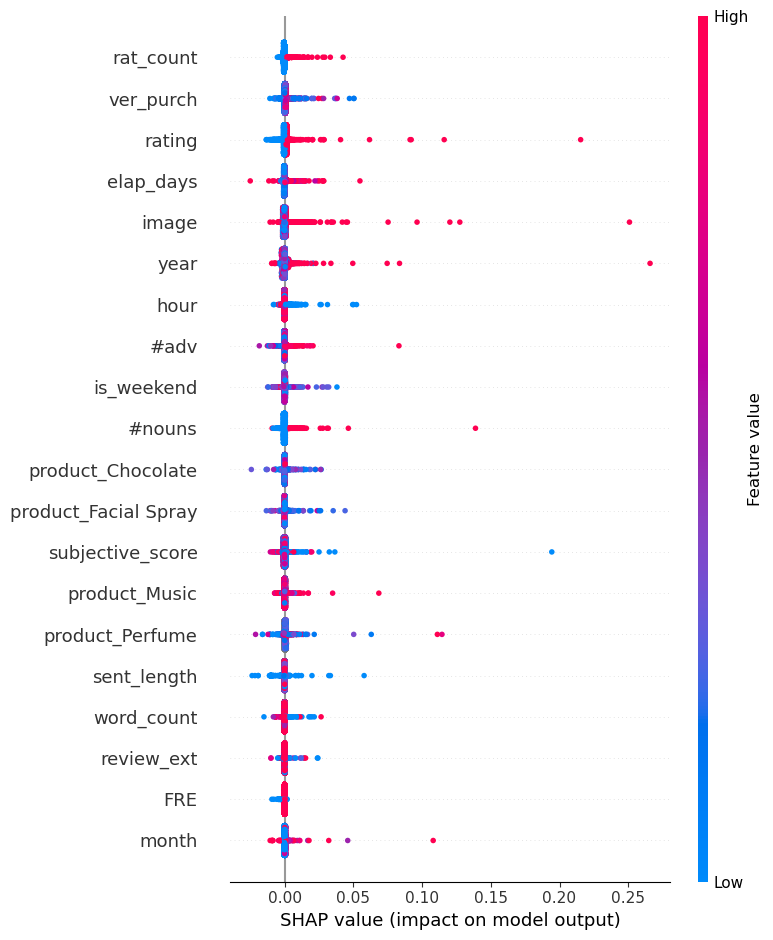

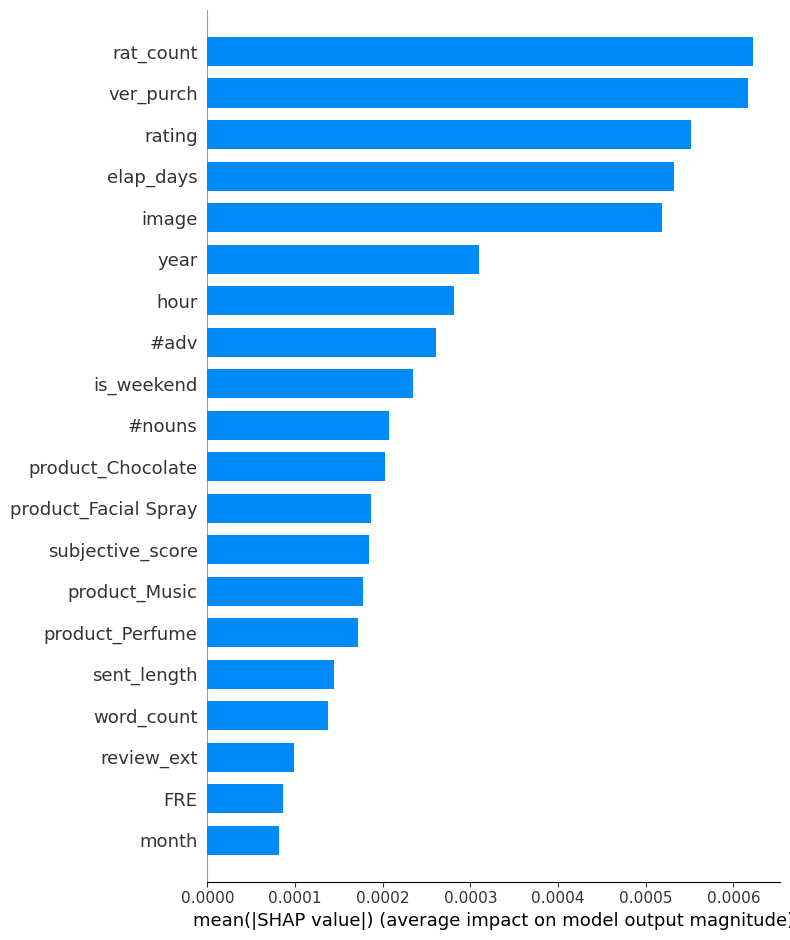

In [23]:
# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_reg_default)

# Calculate SHAP values for the dataset
shap_values = explainer.shap_values(X_train_scaled_df)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_train_scaled_df)

# Create a beeswarm plot
shap.summary_plot(shap_values, X_train_scaled_df, plot_type="bar", show=False)
plt.show()

In [24]:
# Create the SHAP explainer for the model
explainer = shap.TreeExplainer(xgb_reg_default)

# Calculate SHAP values for the training set
shap_values_train = explainer.shap_values(X_train_scaled_df)


[18:36:51] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


KeyboardInterrupt: 

In [ ]:
# Calculate the mean of the absolute SHAP values for each feature
average_shap_values_train = np.abs(shap_values_train).mean(axis=0)


In [ ]:
# Create a DataFrame for the features and their average SHAP values
shap_df_train = pd.DataFrame({
    'features': X_train_scaled_df.columns,
    'average_shap_value': average_shap_values_train
})

# Sort the DataFrame based on the average SHAP values
shap_df_train_sorted = shap_df_train.sort_values(by='average_shap_value', ascending=False)

# Display the sorted DataFrame
print(shap_df_train_sorted)

                features  average_shap_value
14             ver_purch            0.001028
2              rat_count            0.000960
9              elap_days            0.000655
0                 rating            0.000566
10                 image            0.000451
11                  year            0.000409
13                  hour            0.000292
20            is_weekend            0.000266
7           title_length            0.000234
17                  #adv            0.000232
5             sent_count            0.000205
21     product_Chocolate            0.000192
22  product_Facial Spray            0.000183
23         product_Music            0.000178
15                #nouns            0.000174
24       product_Perfume            0.000174
18      subjective_score            0.000164
19                   FRE            0.000100
12                 month            0.000086
3                  price            0.000048
8             review_ext            0.000043
16        

In [ ]:
# Calculate SHAP values for the test set
shap_values_test = explainer.shap_values(X_test_scaled_df)


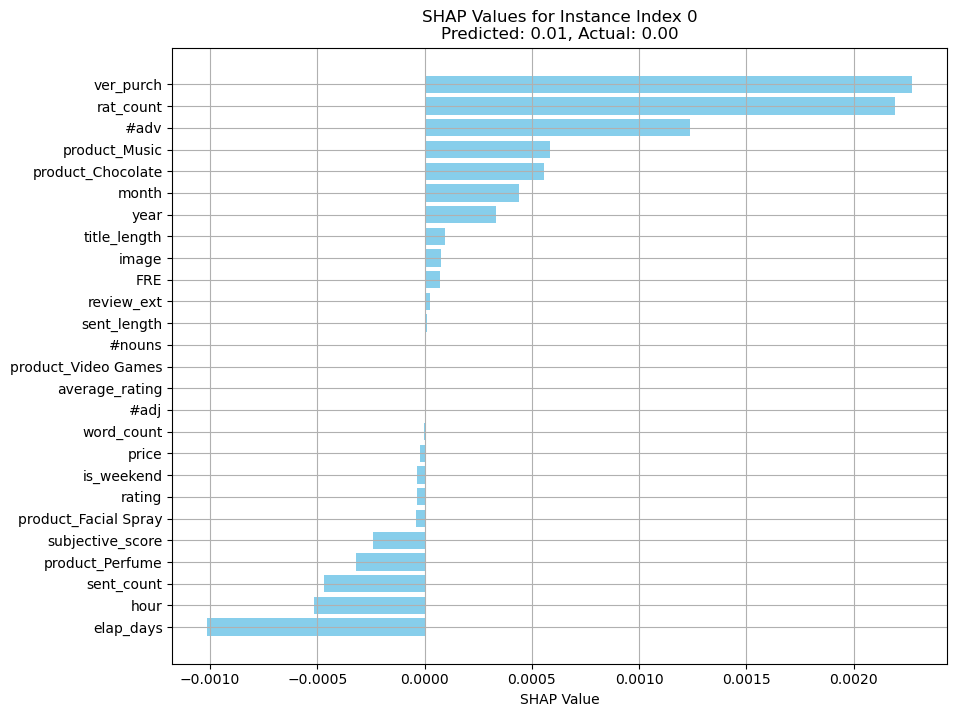

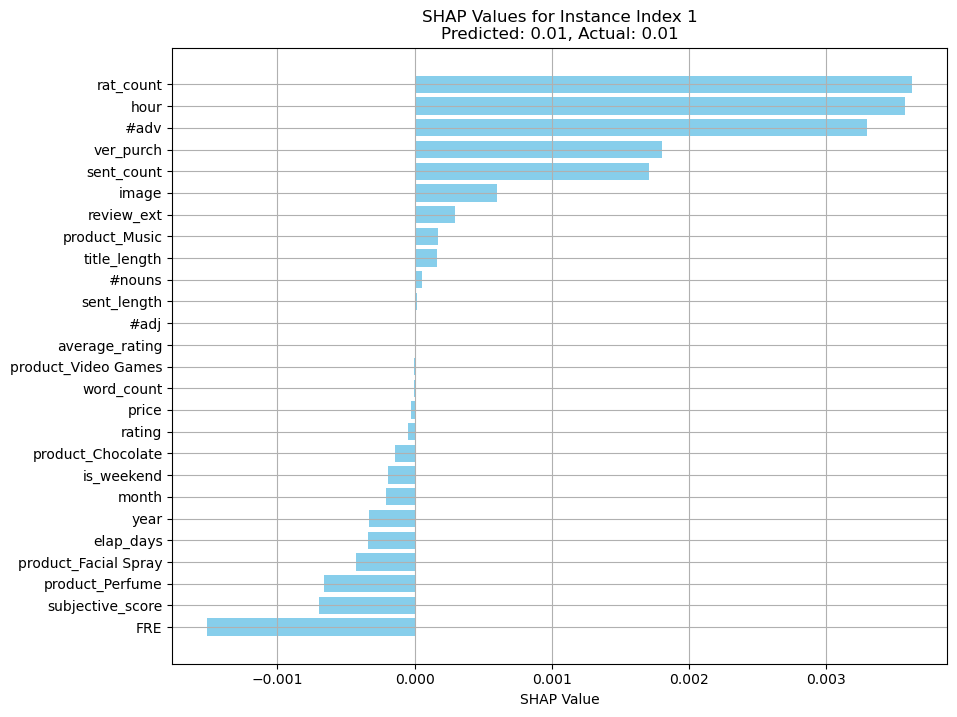

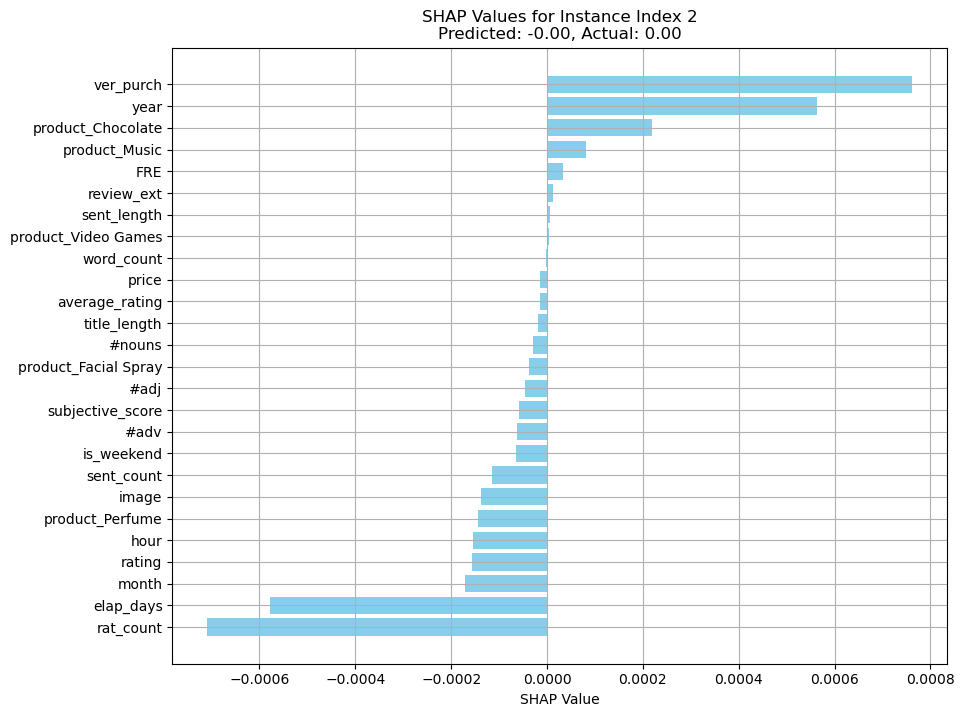

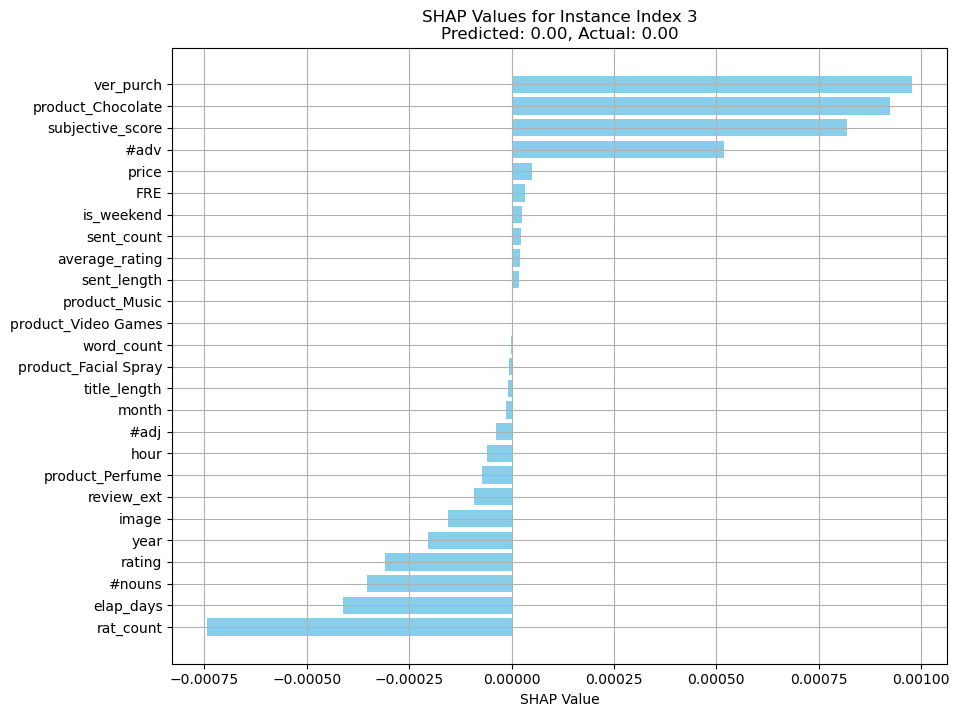

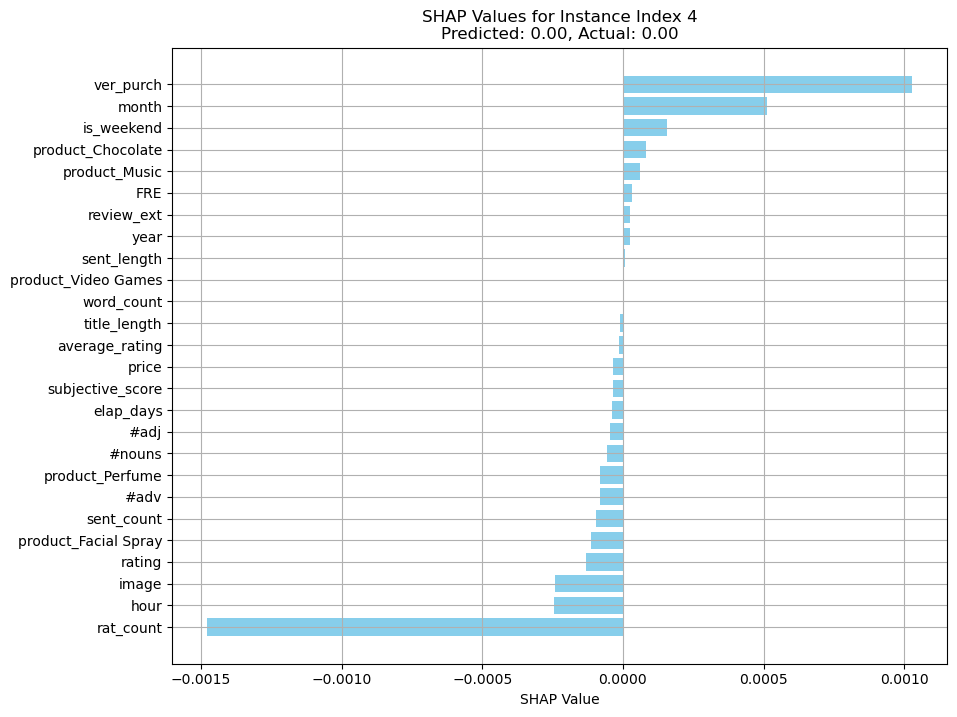

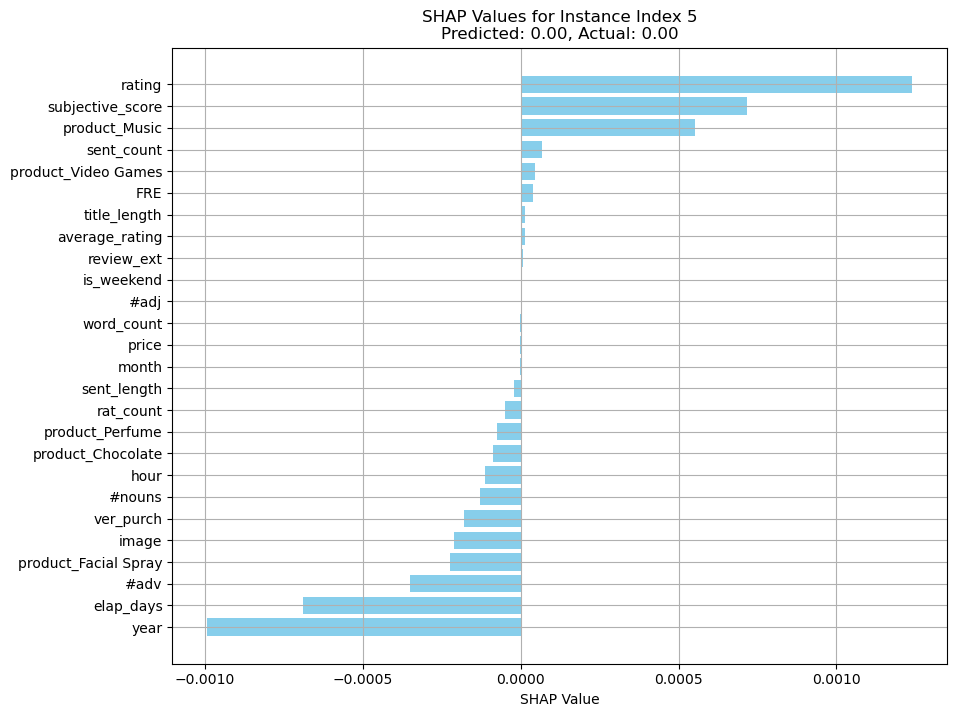

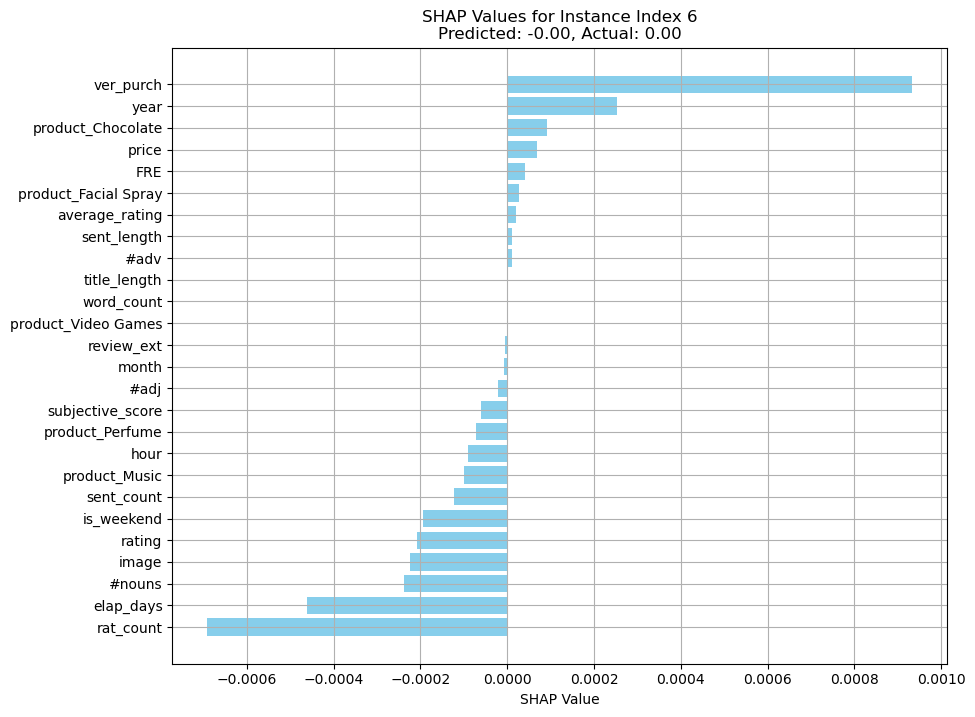

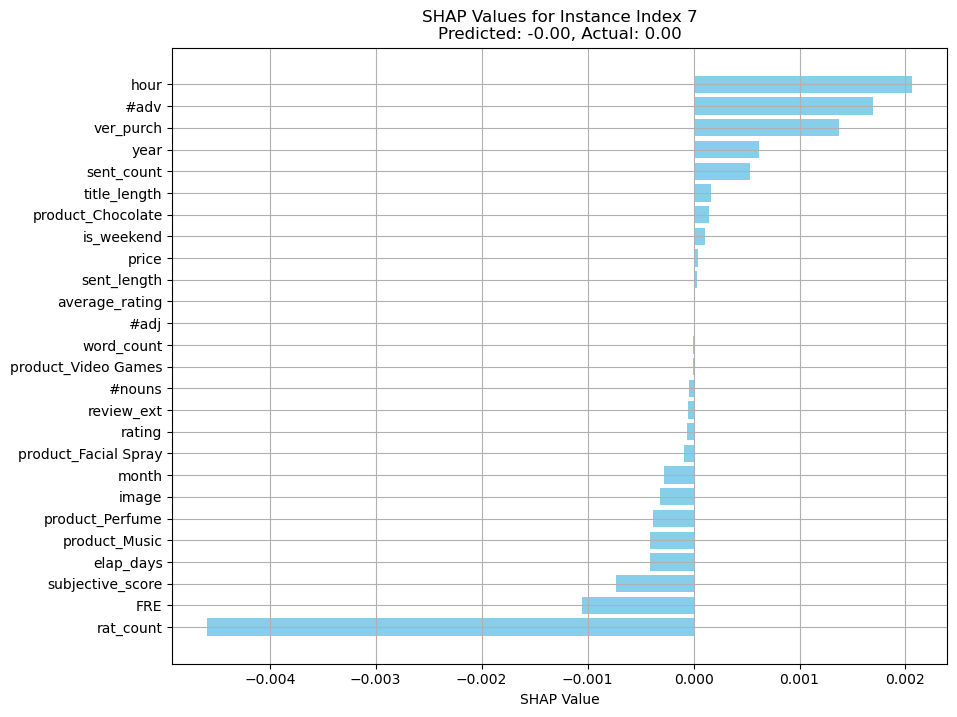

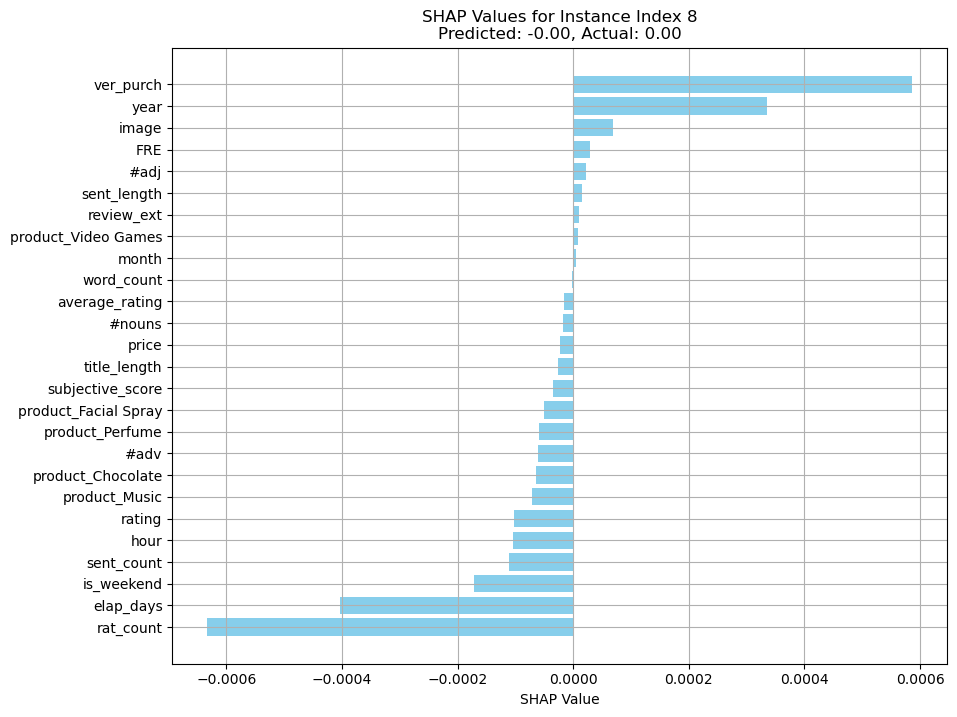

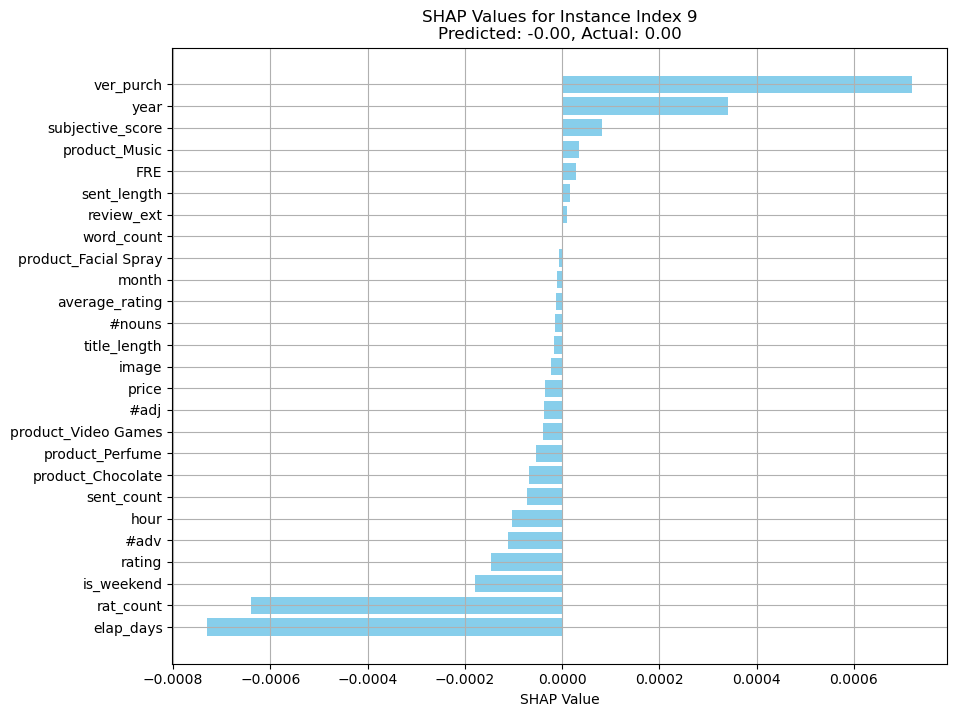

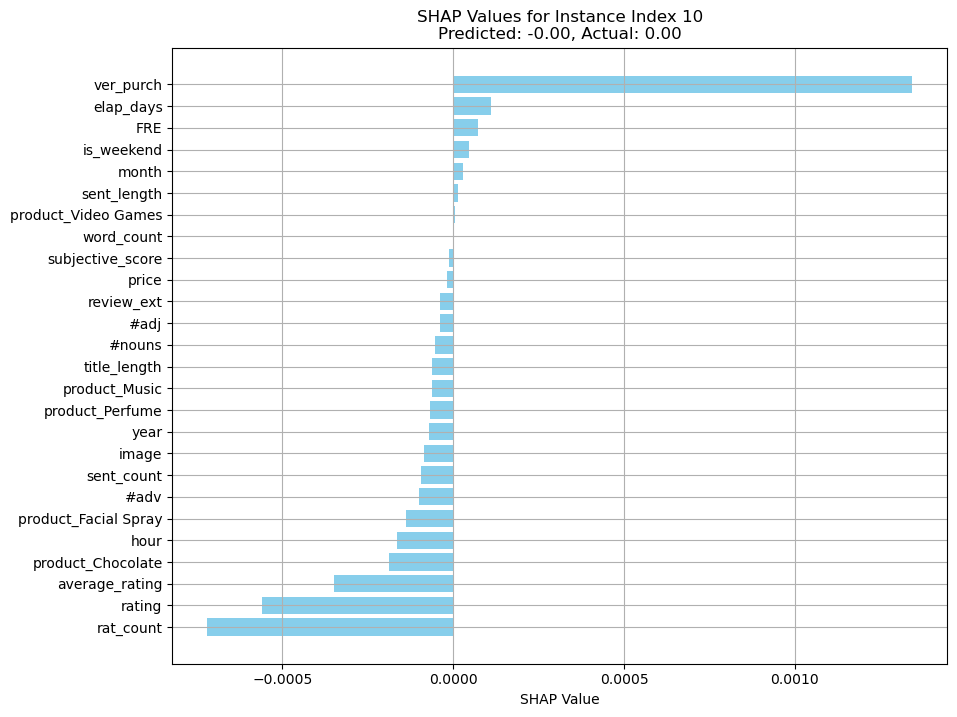

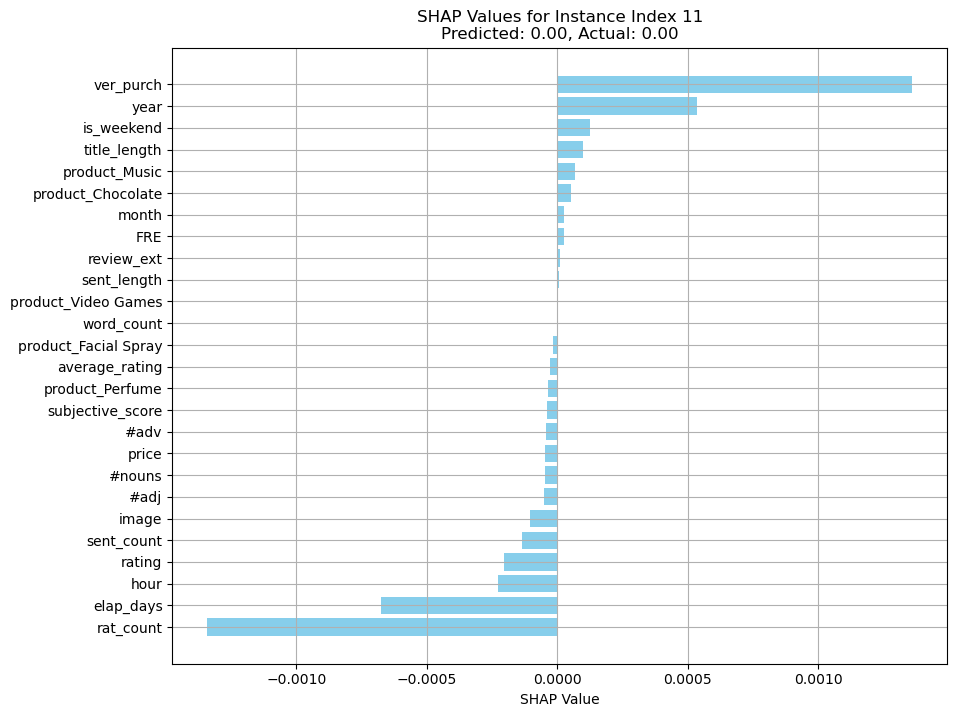

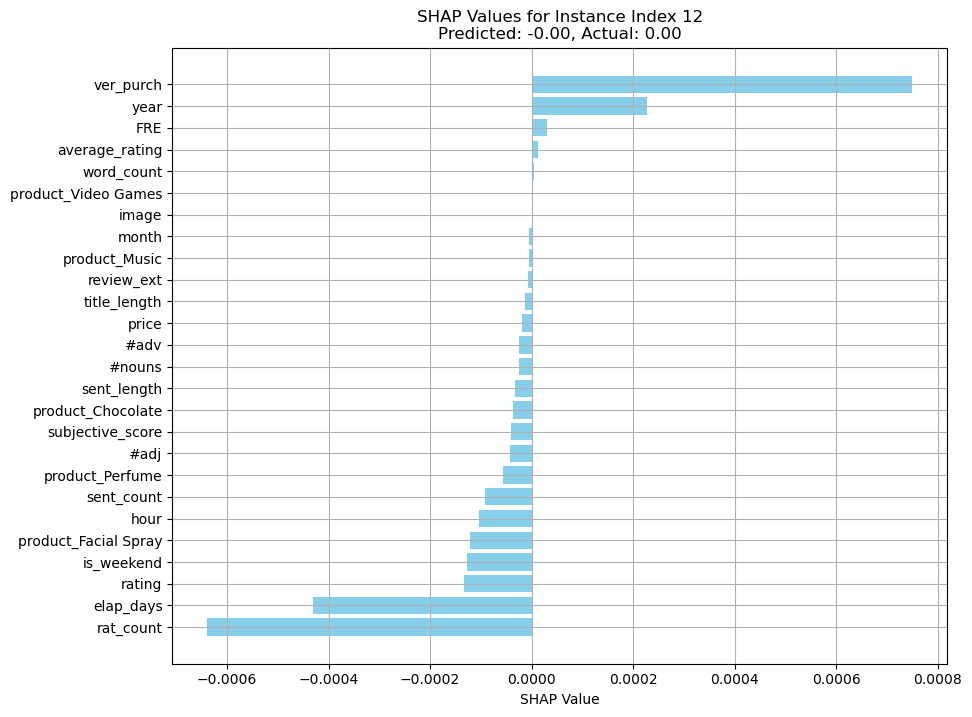

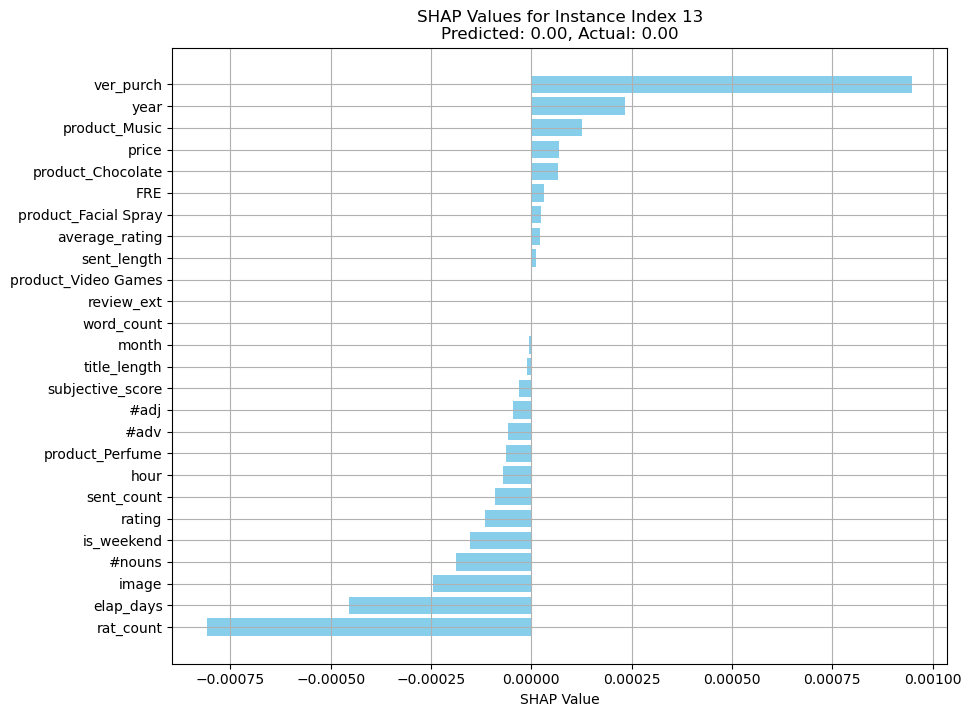

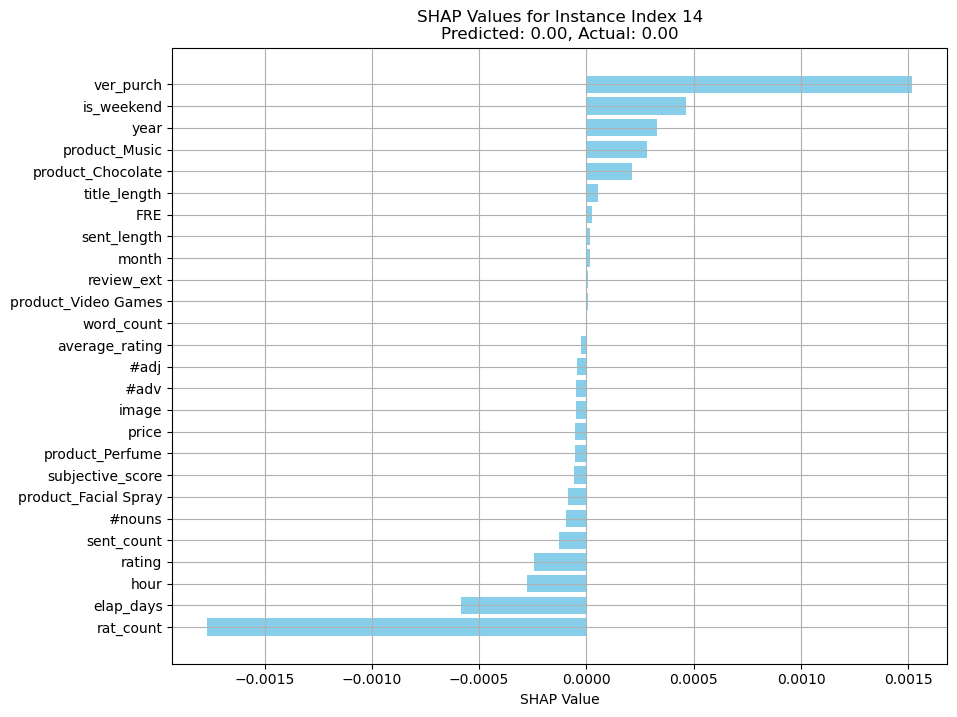

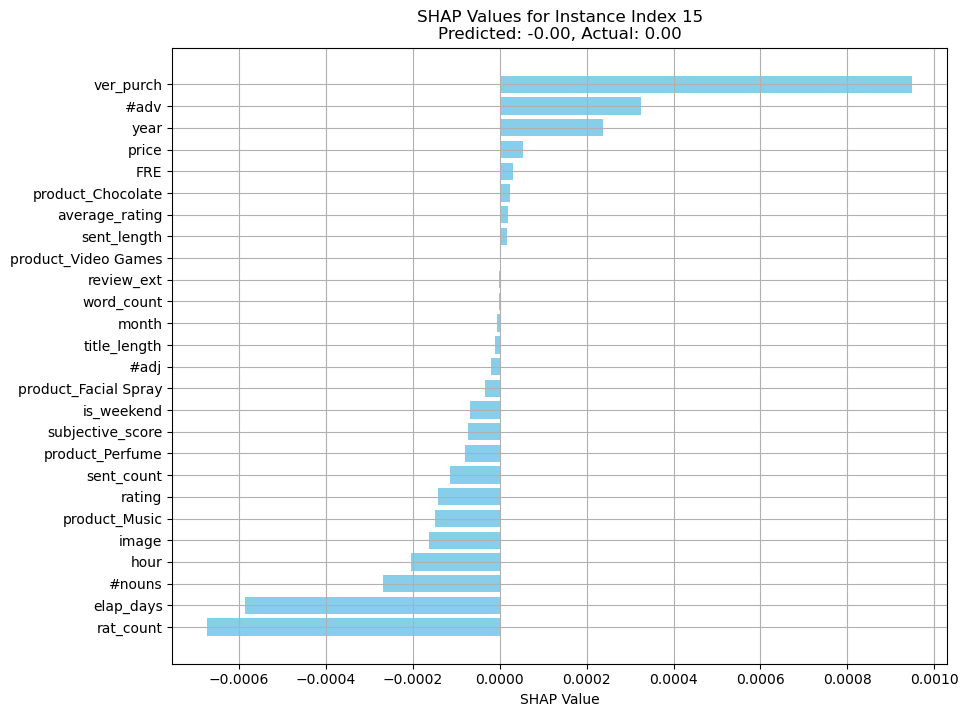

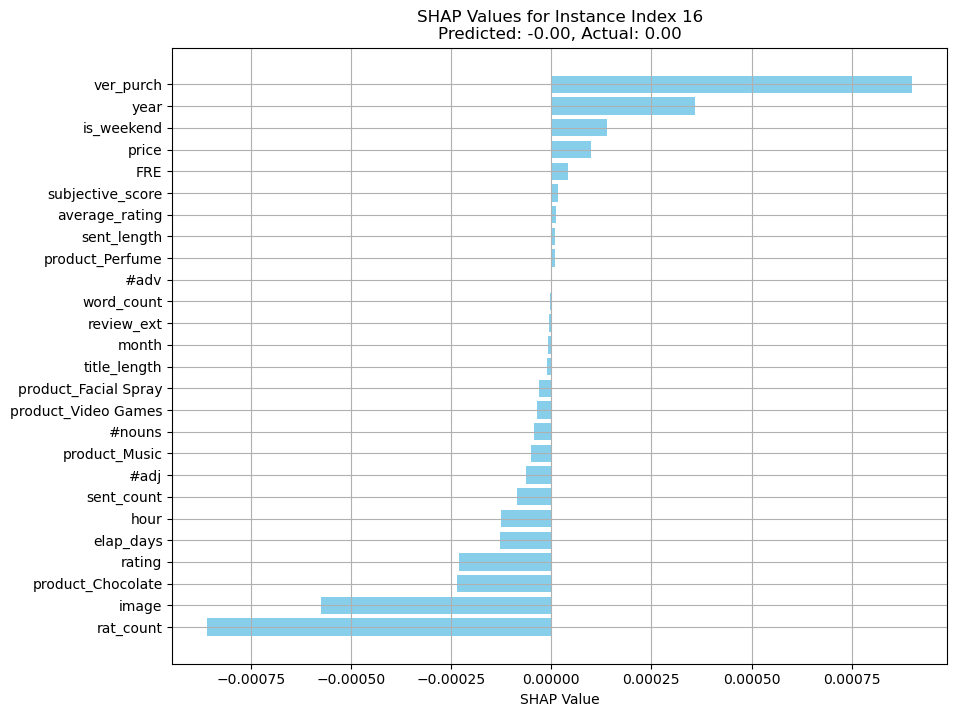

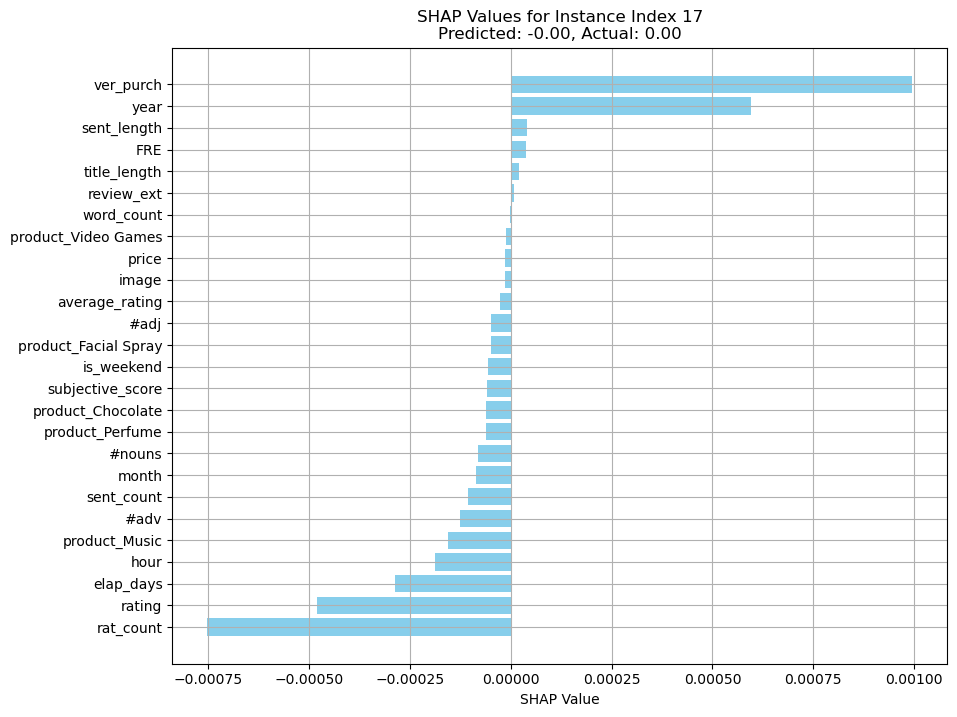

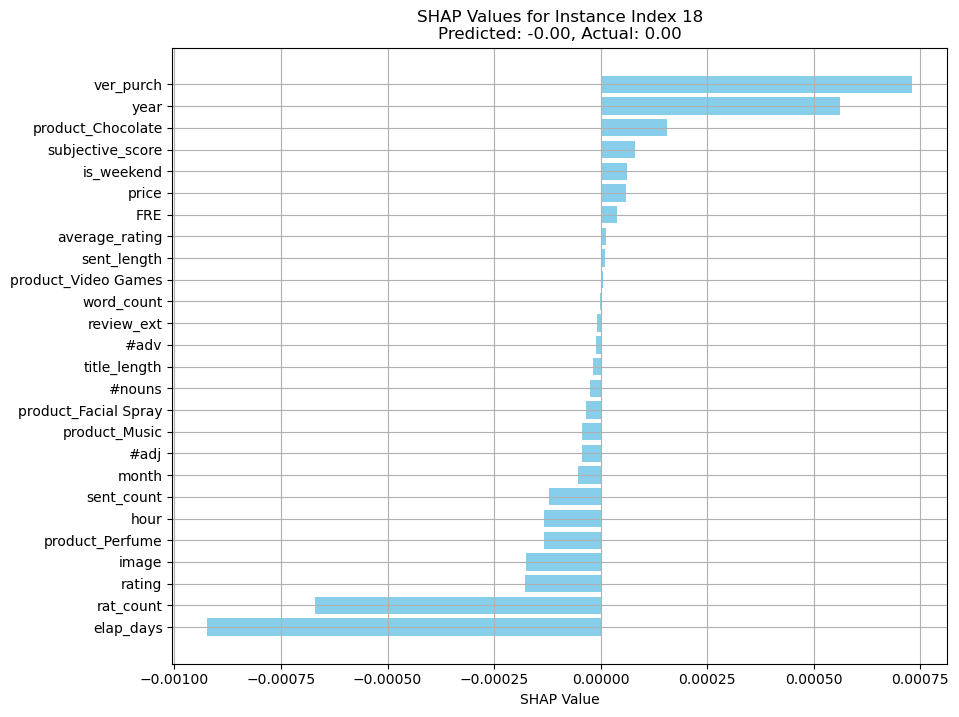

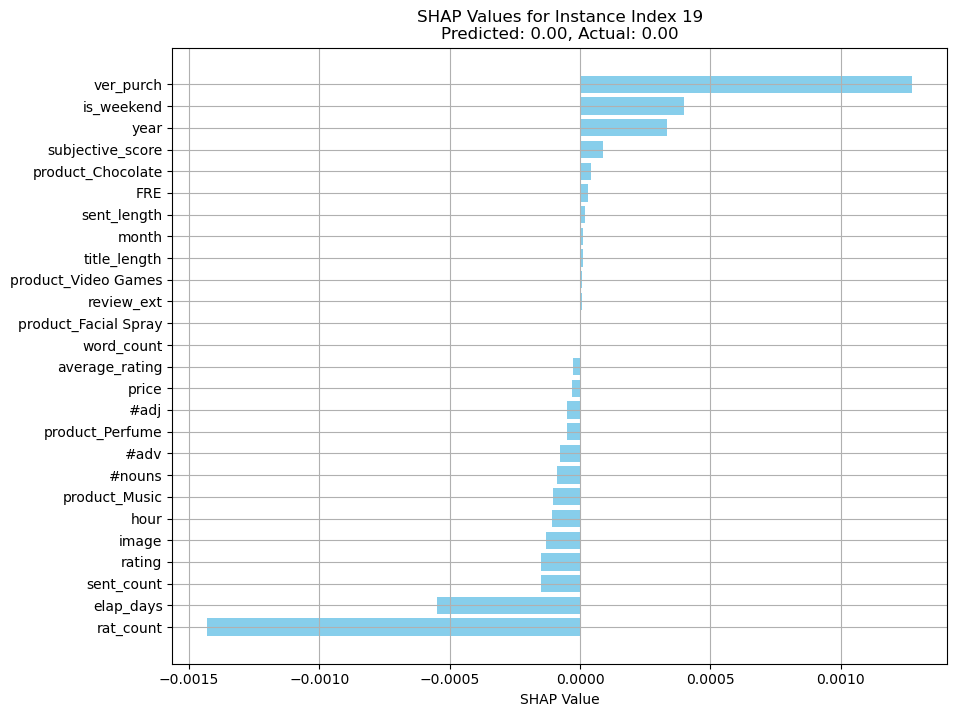

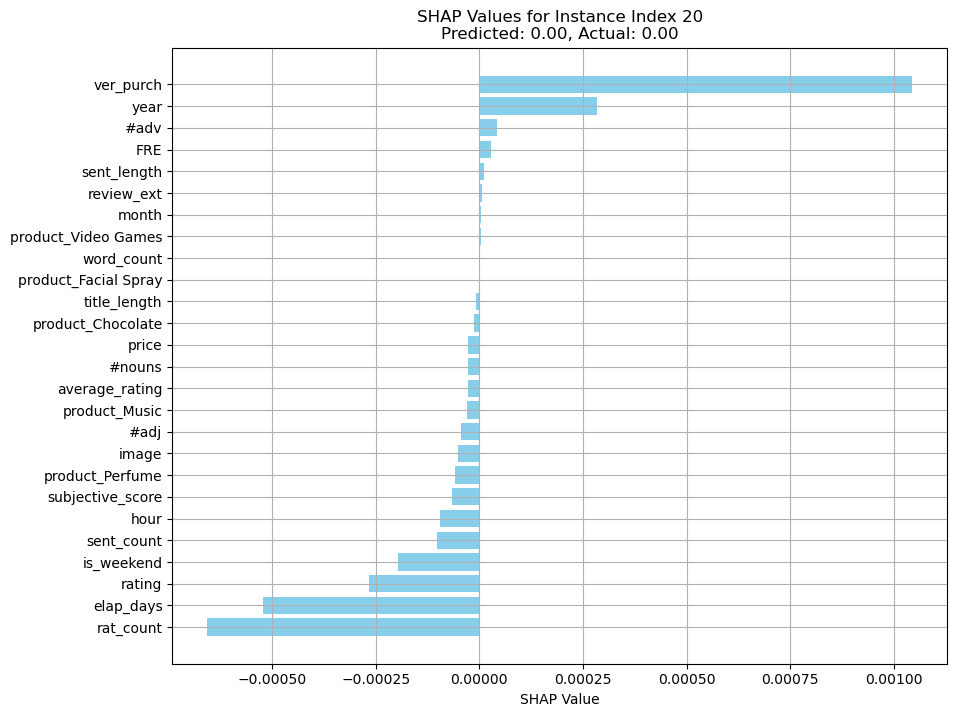

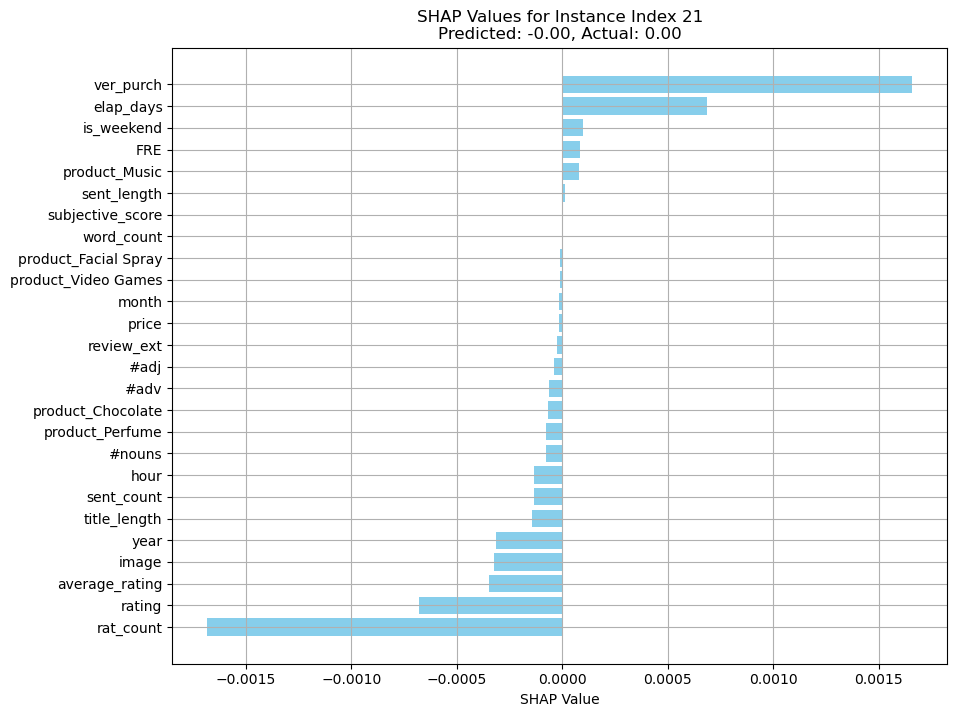

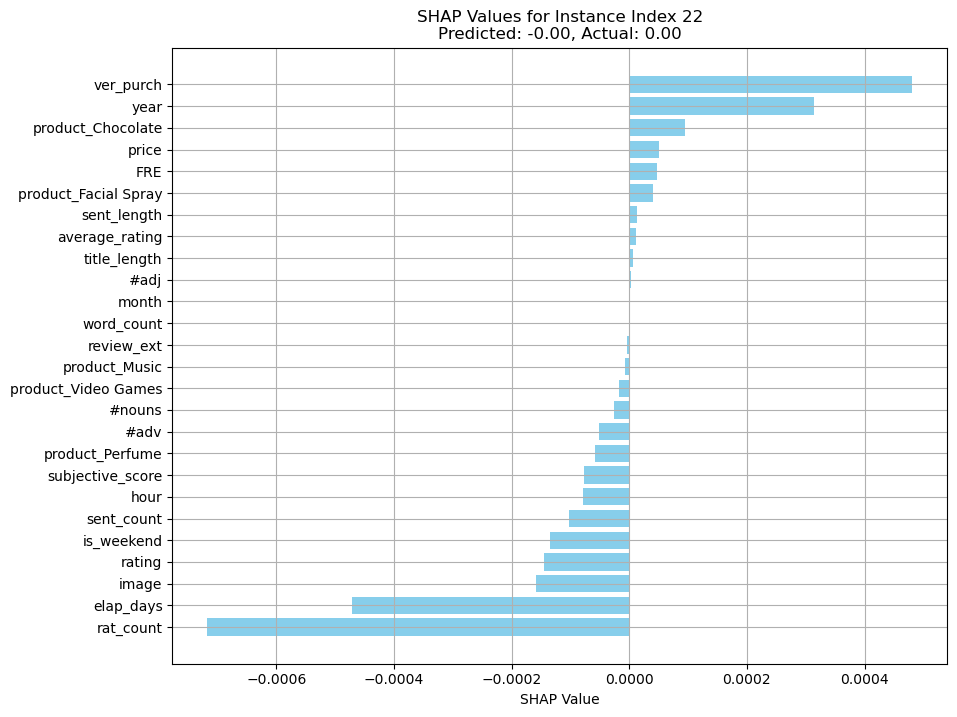

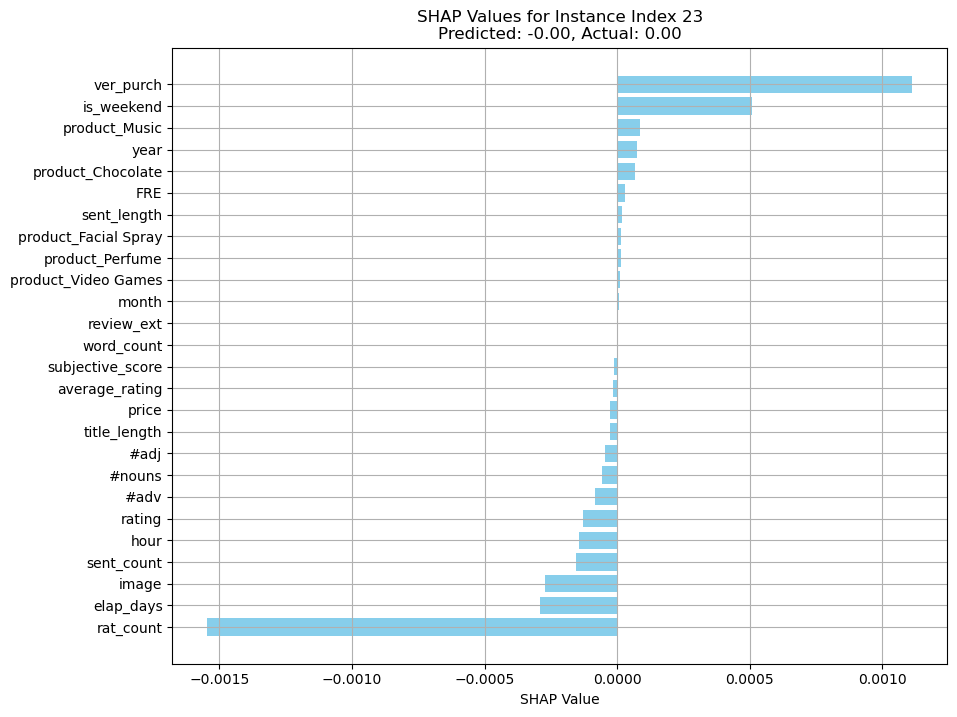

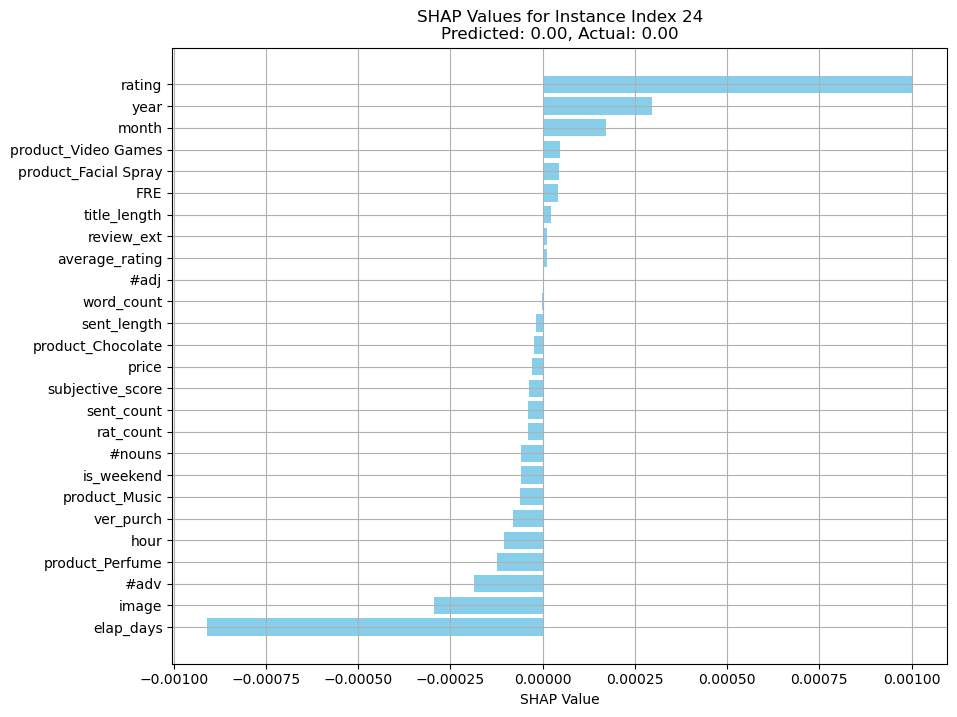

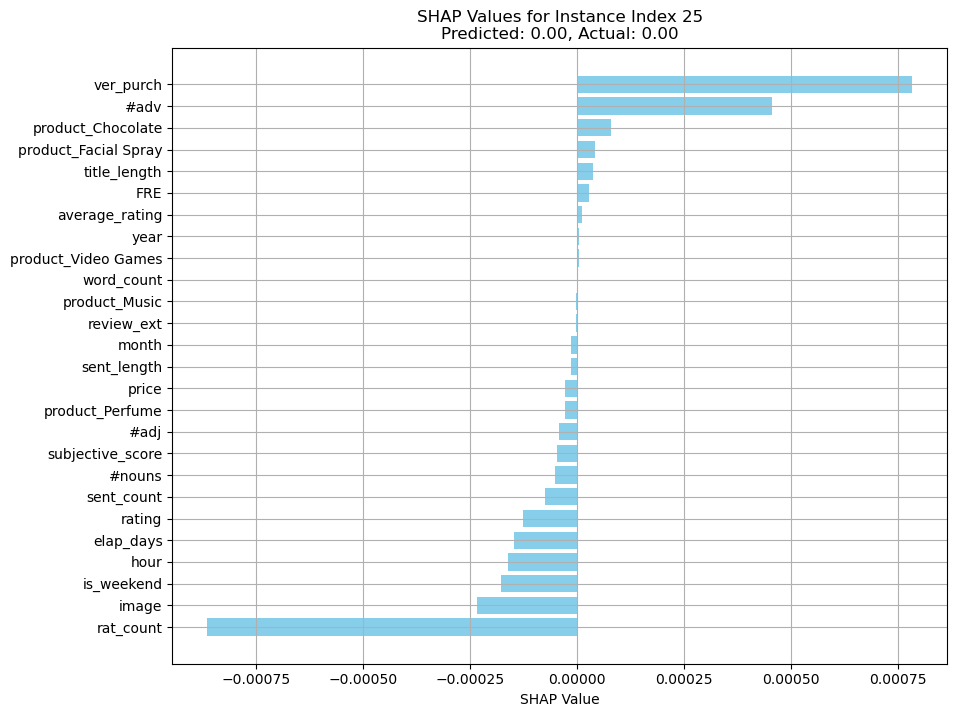

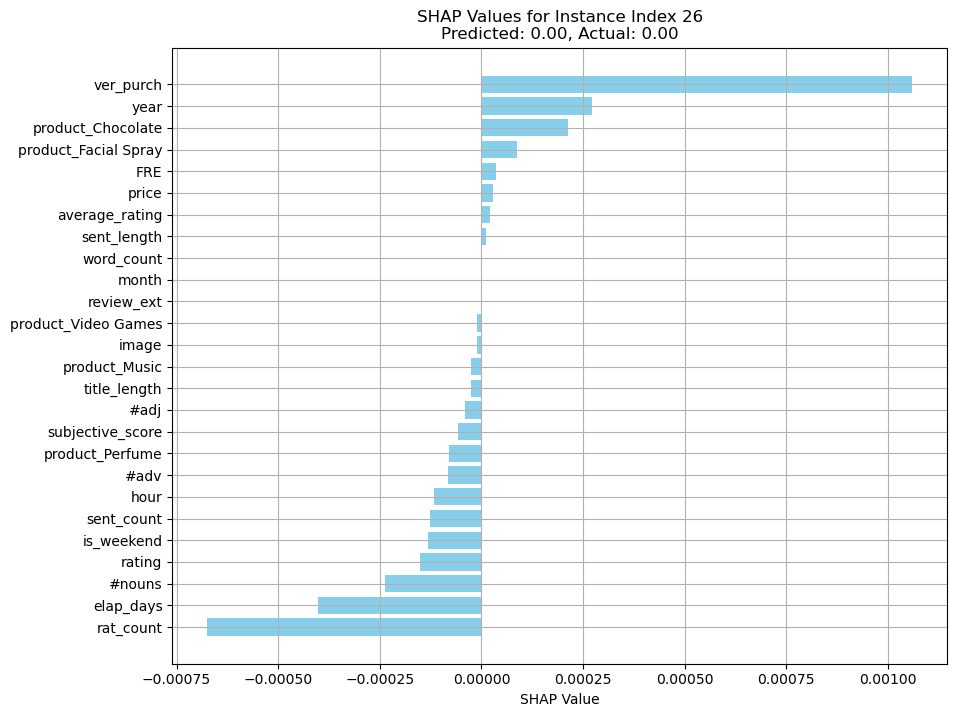

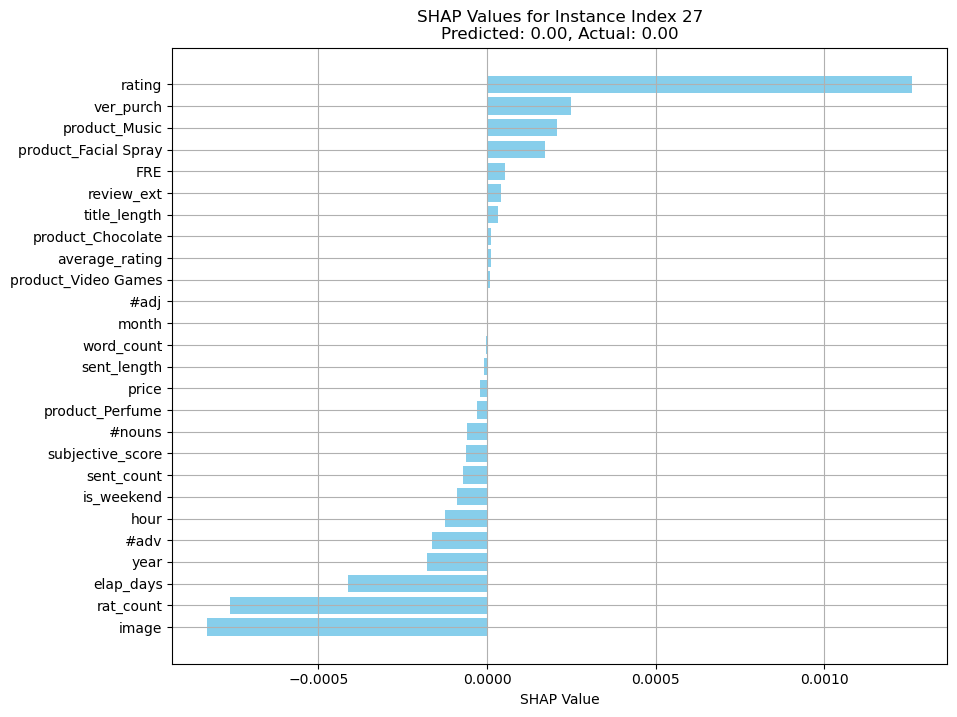

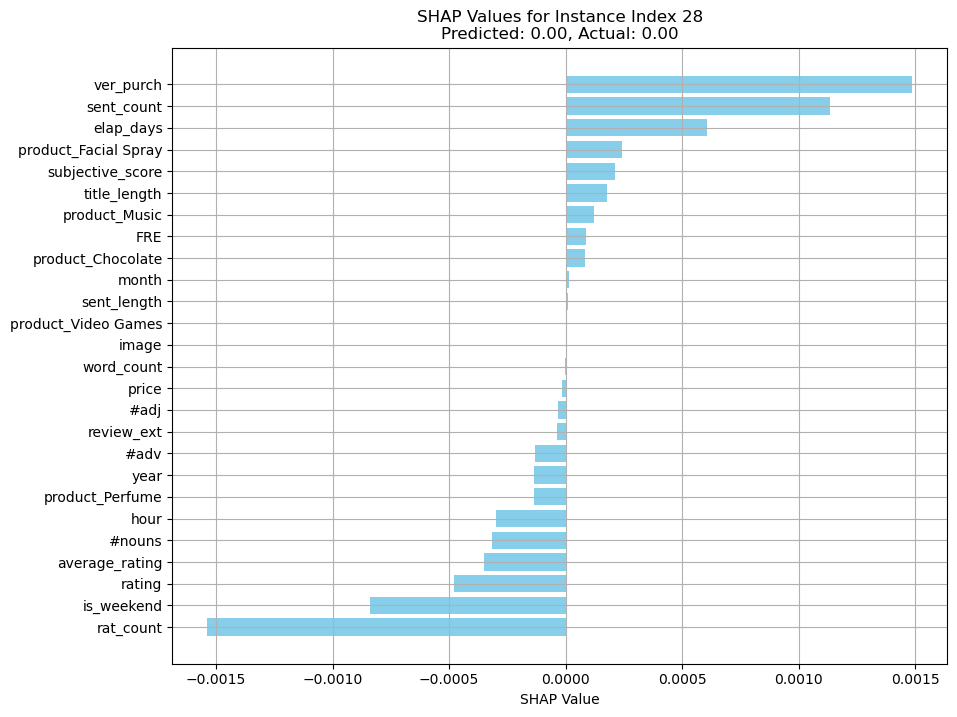

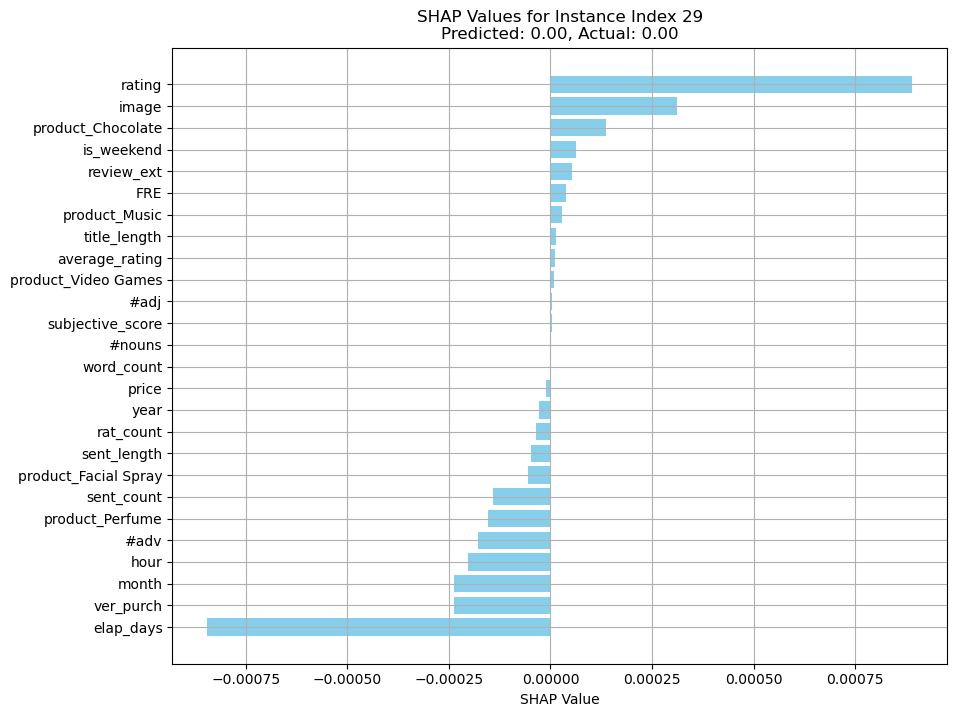

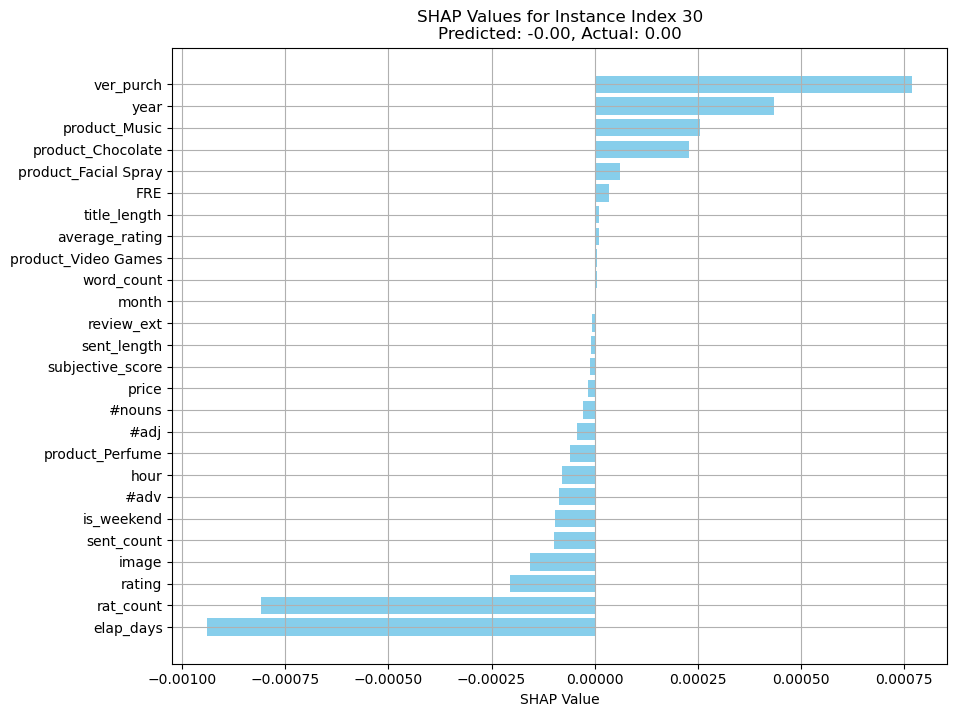

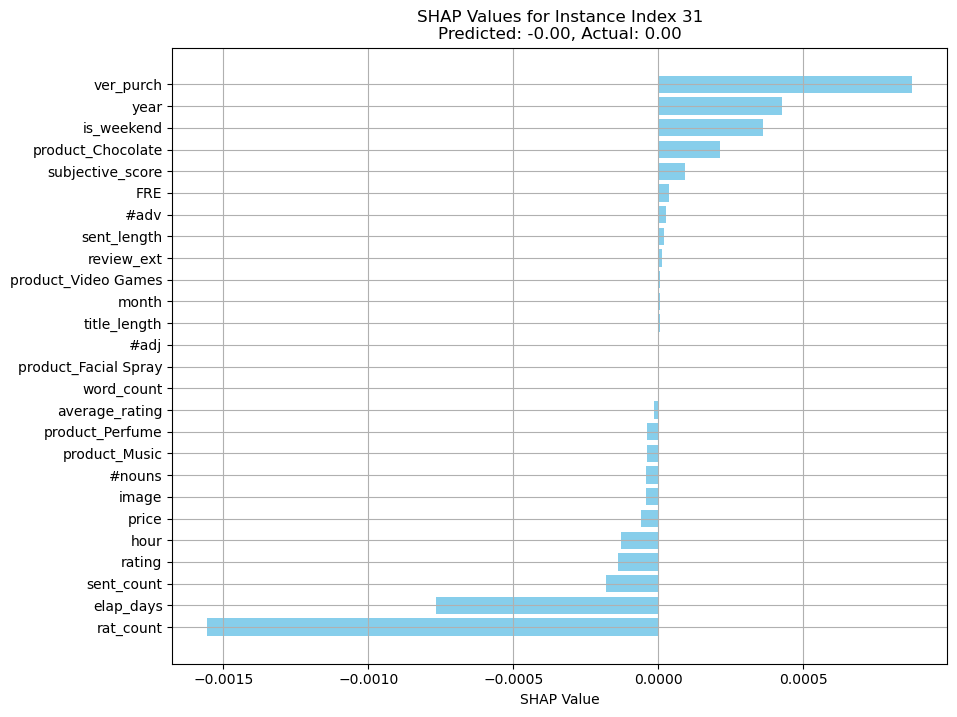

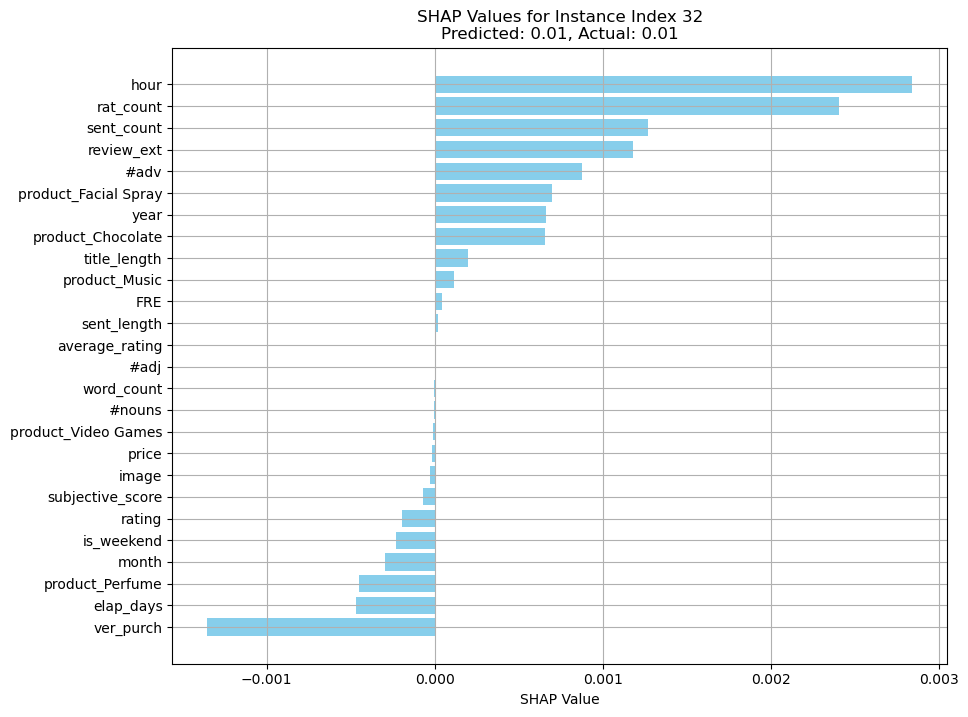

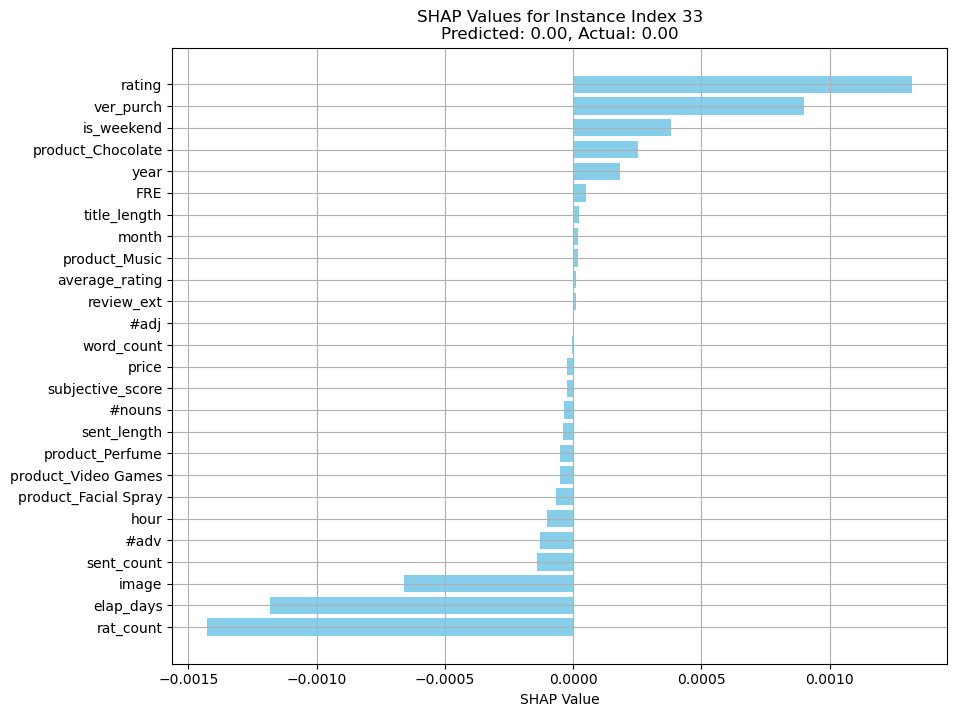

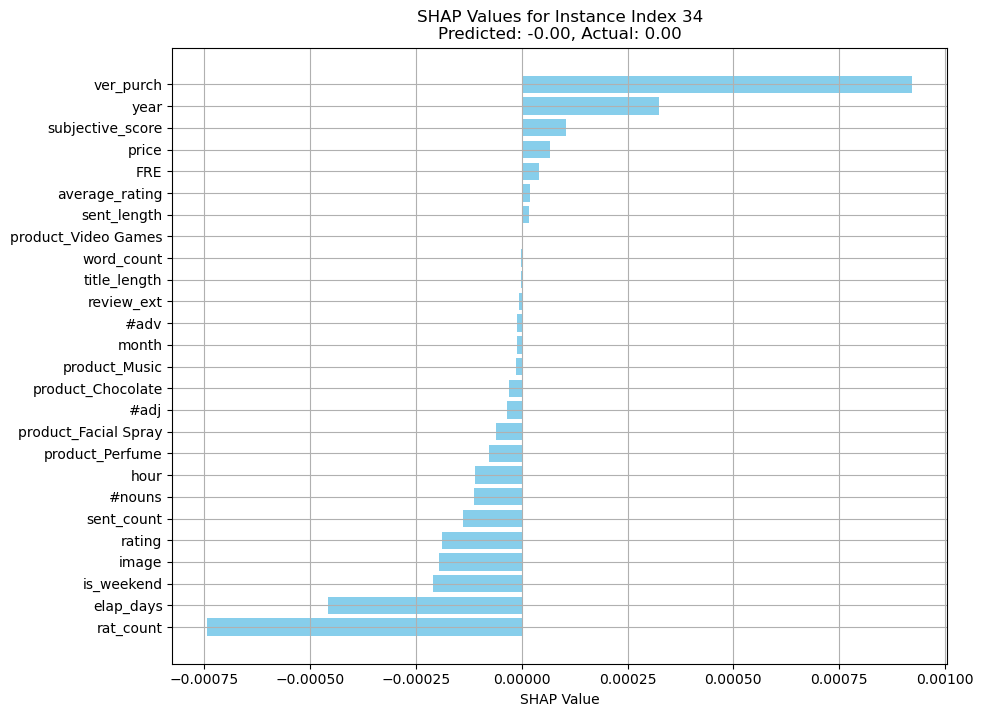

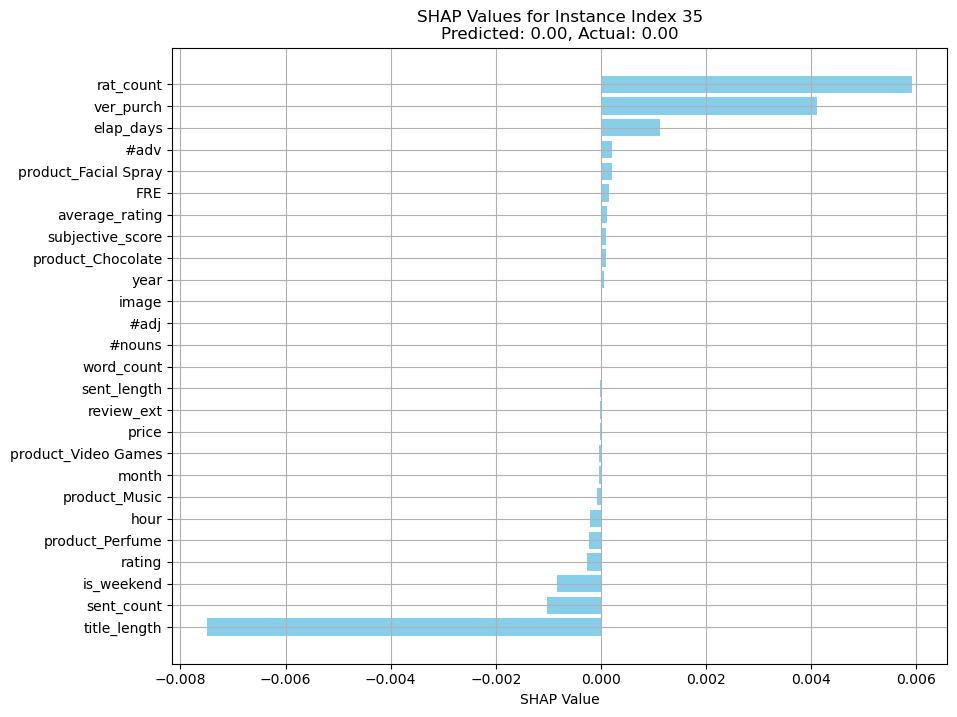

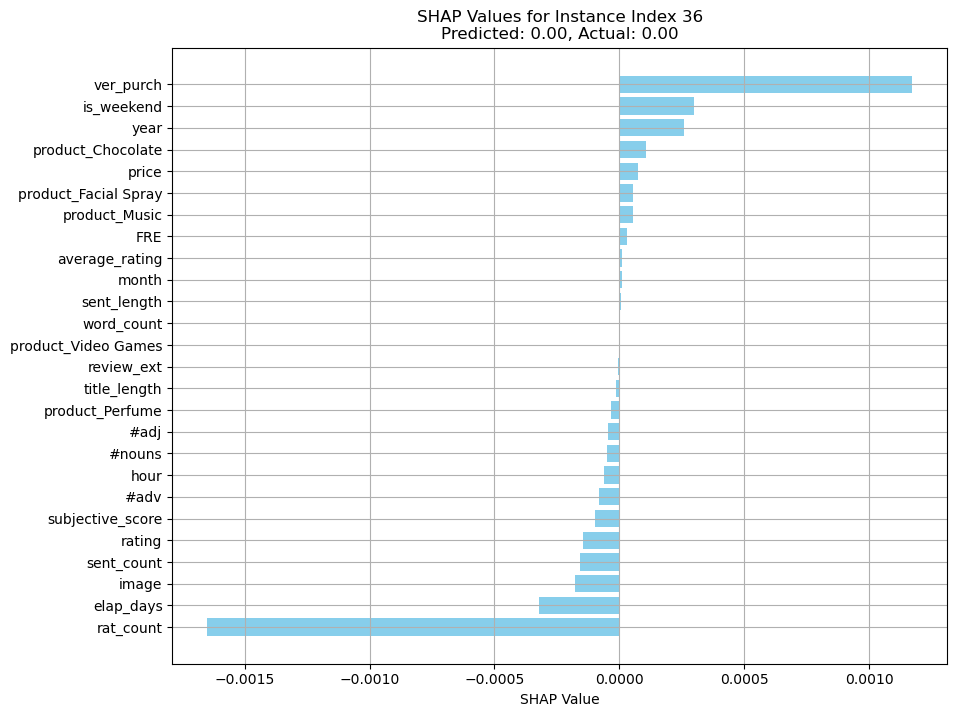

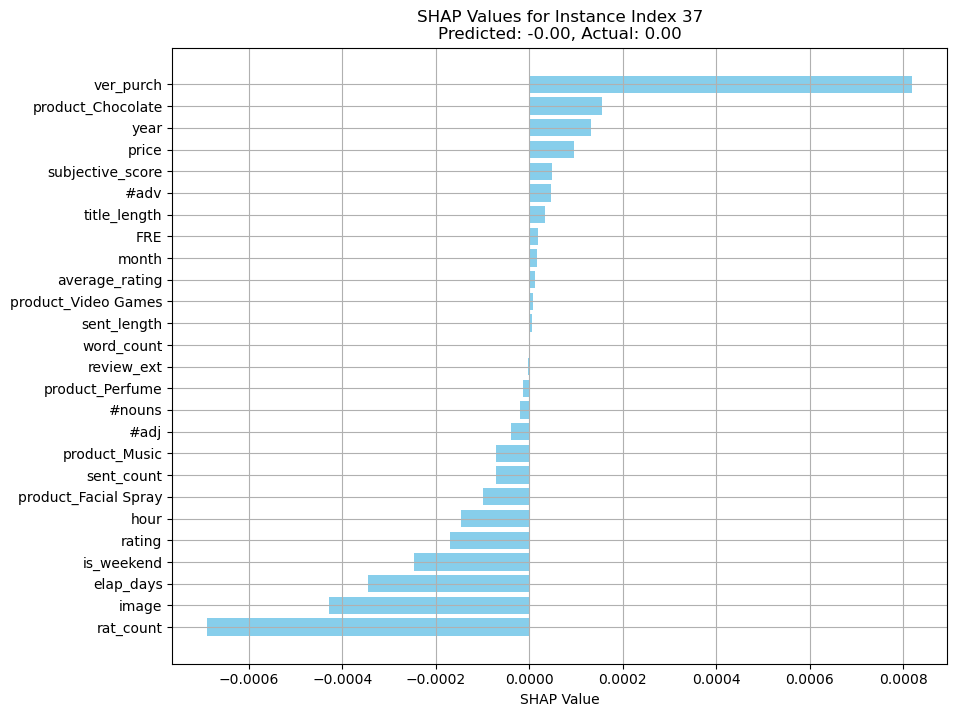

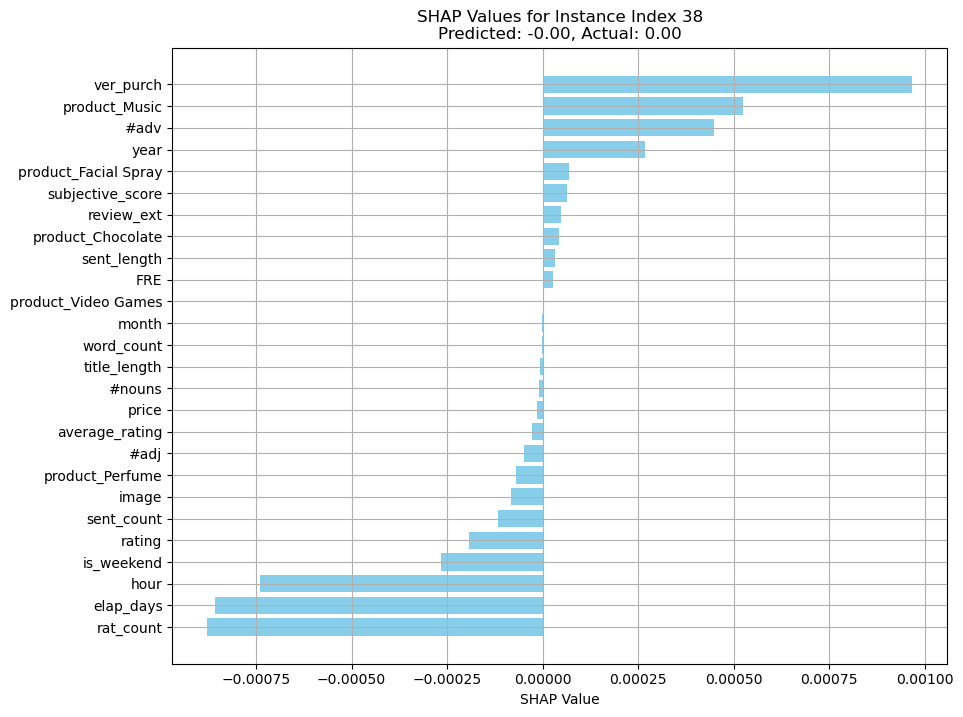

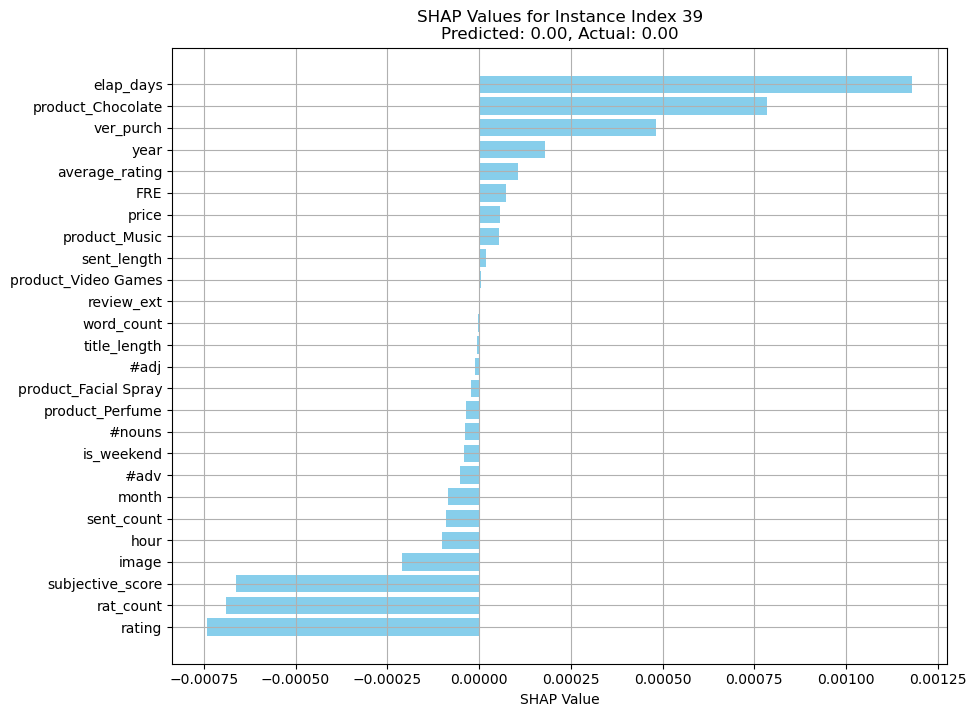

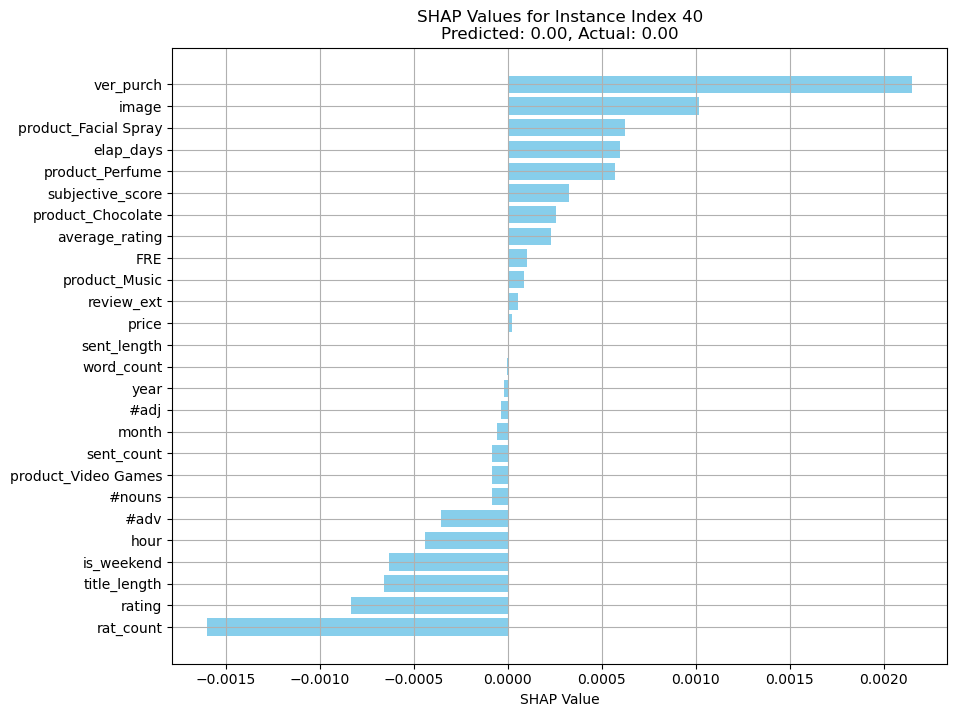

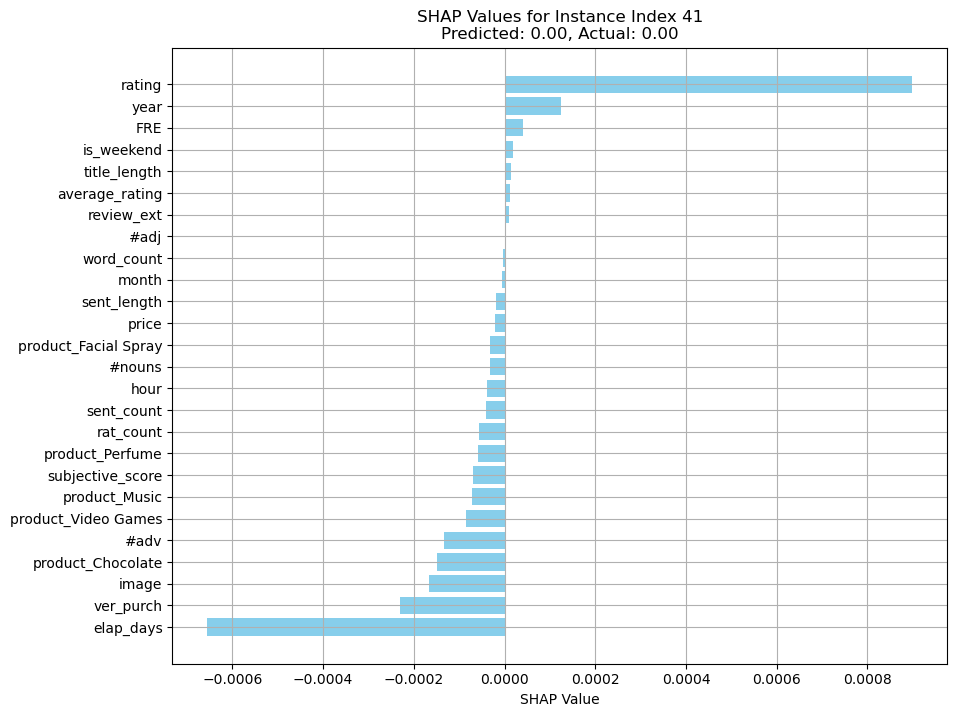

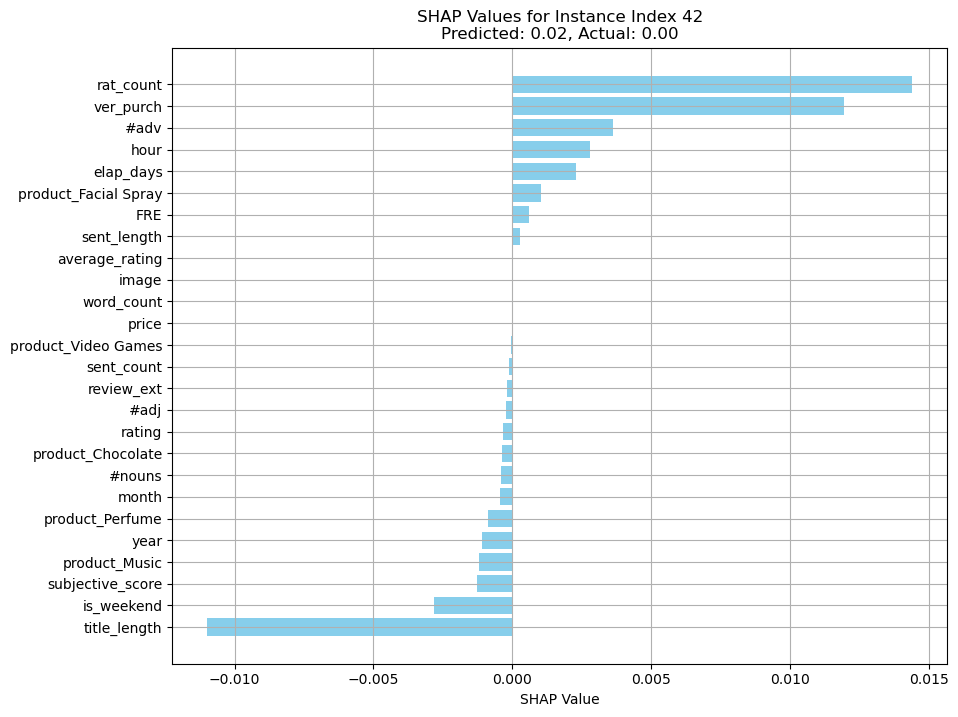

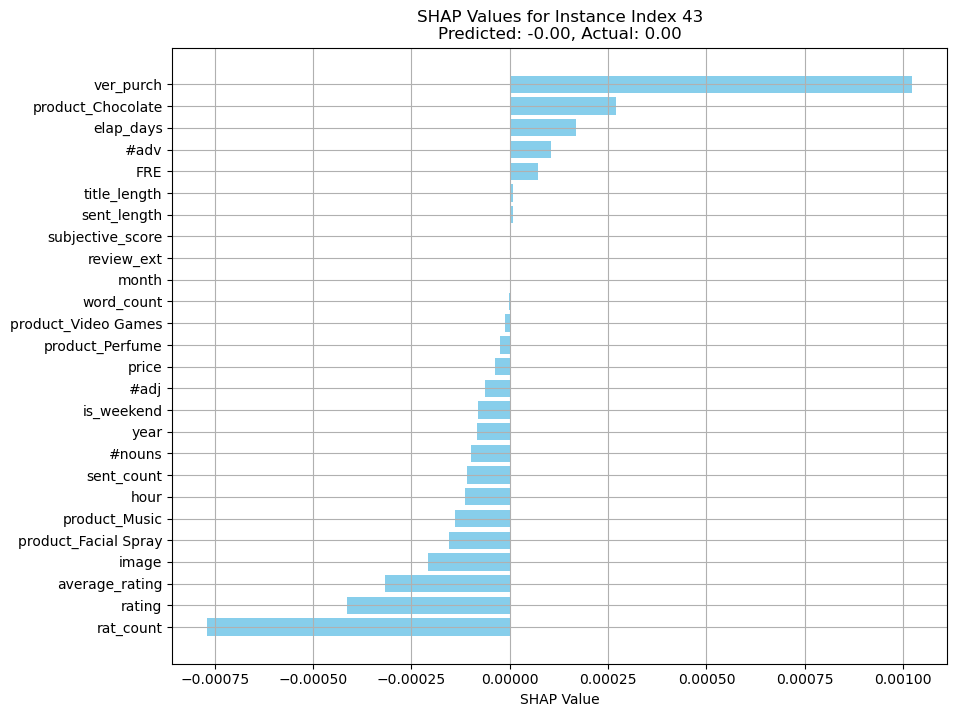

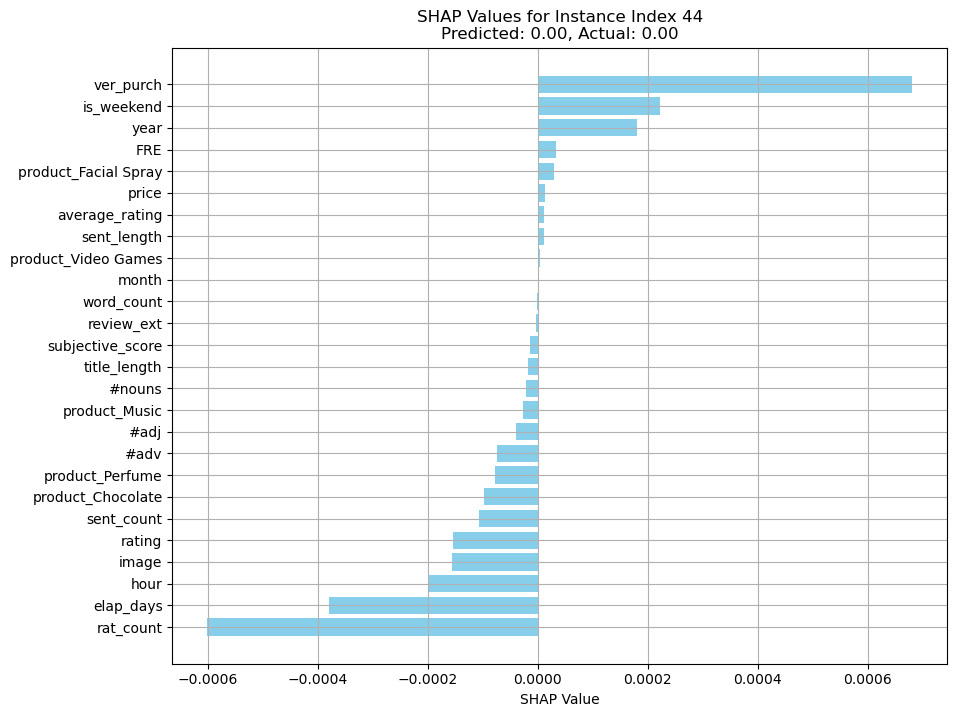

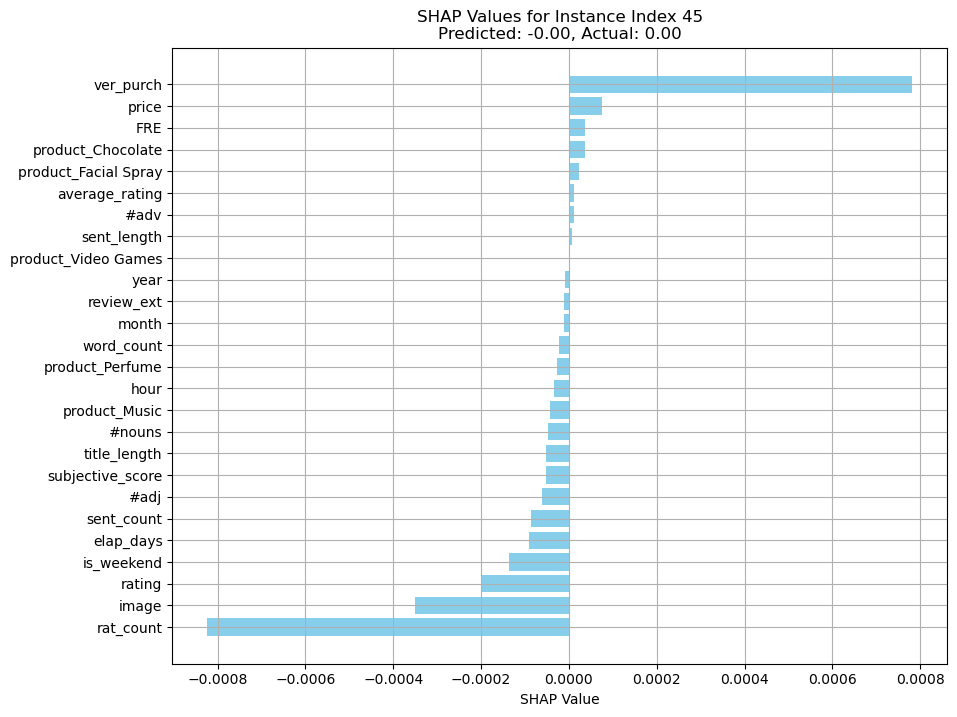

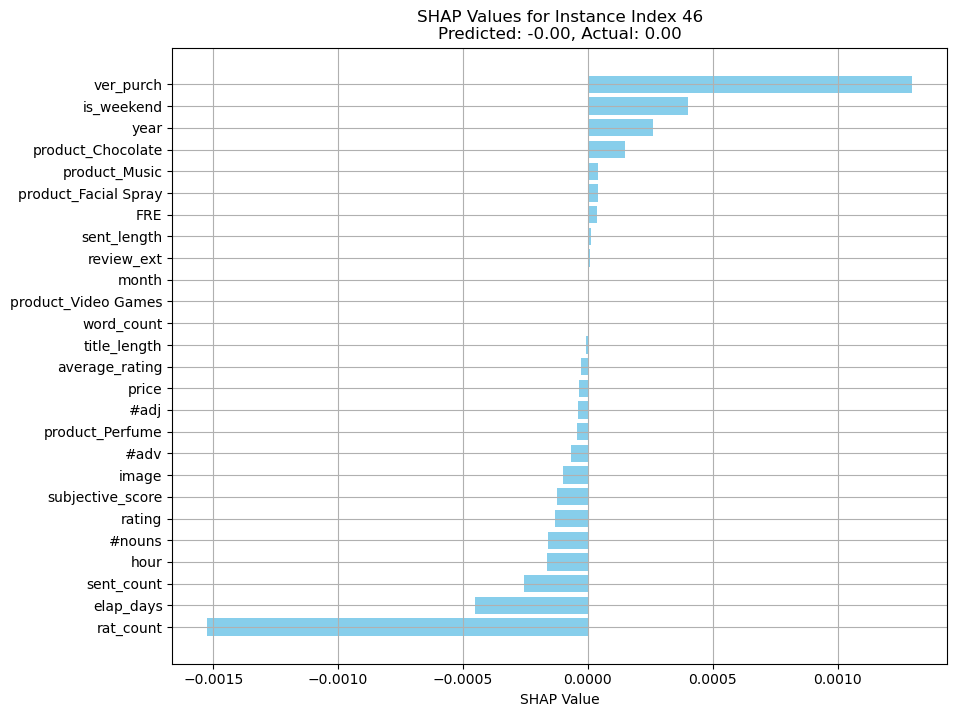

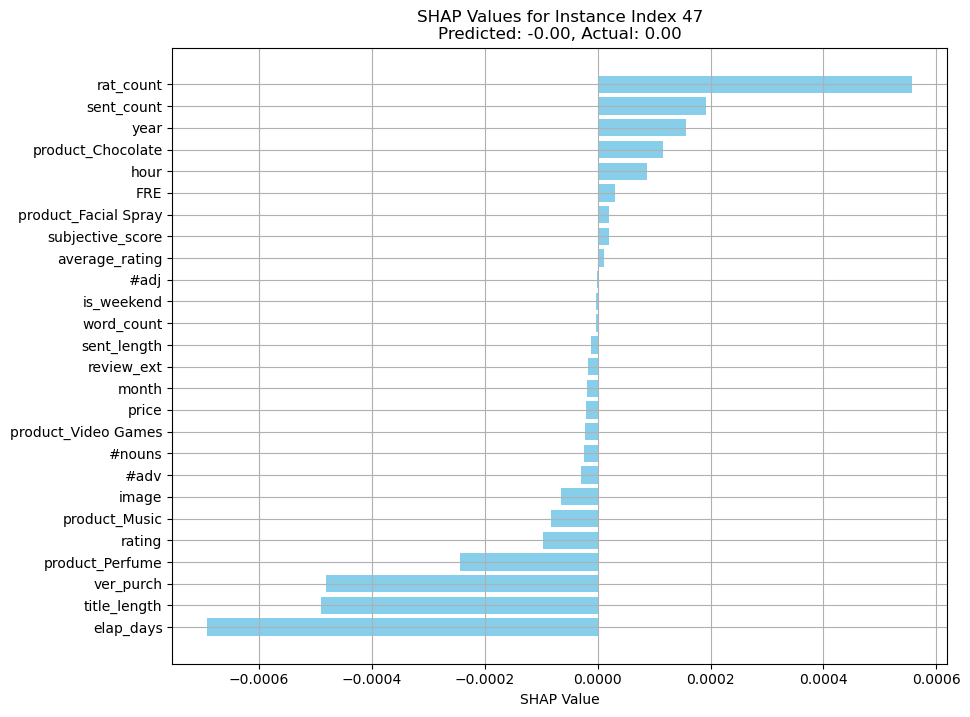

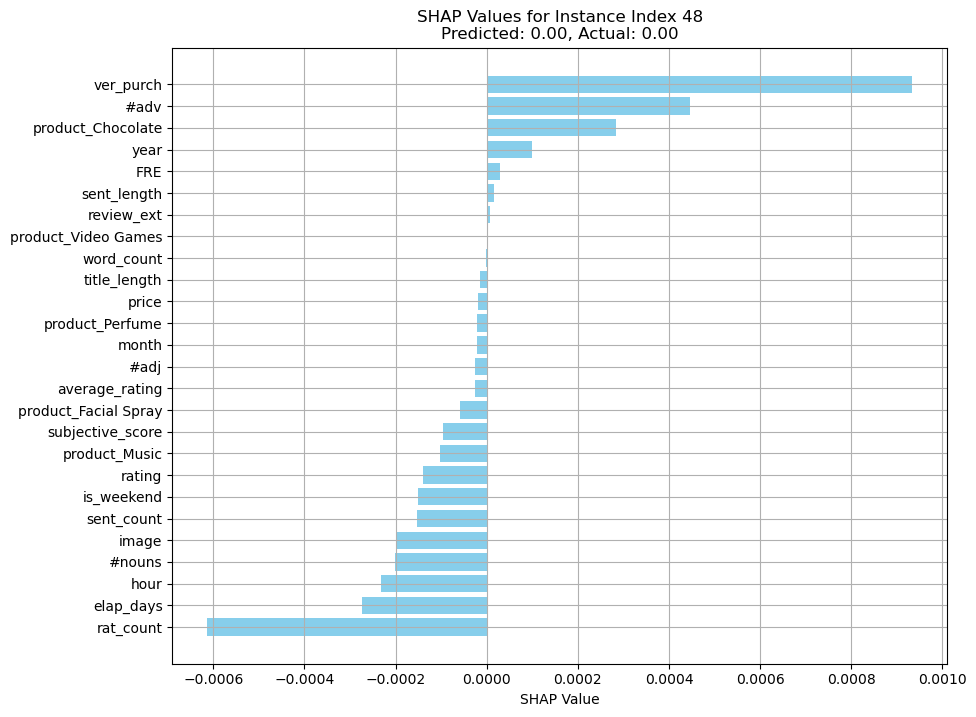

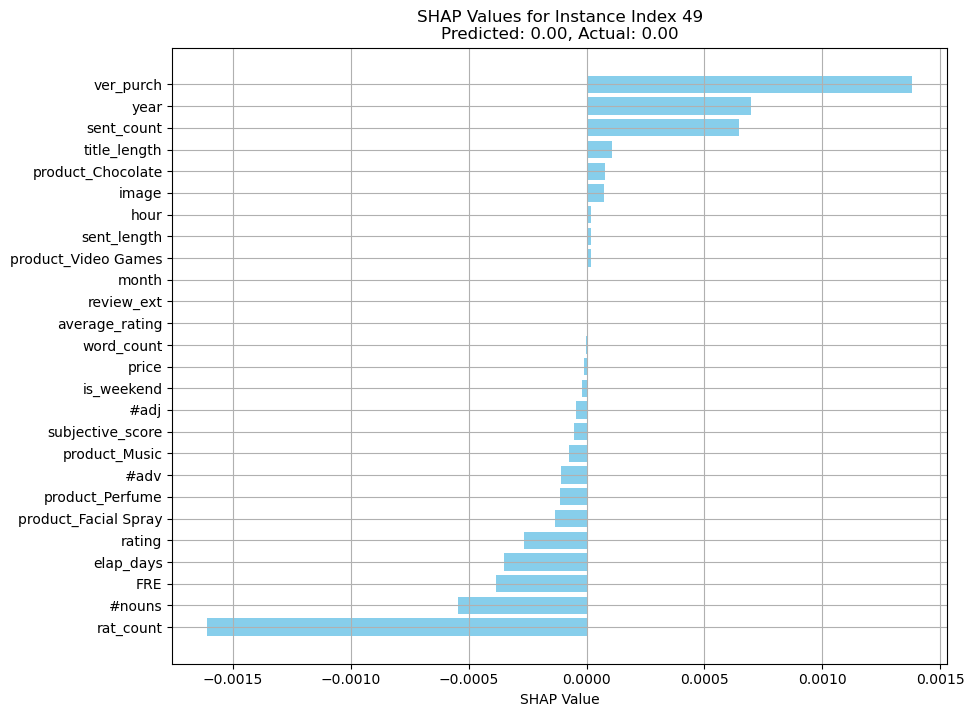

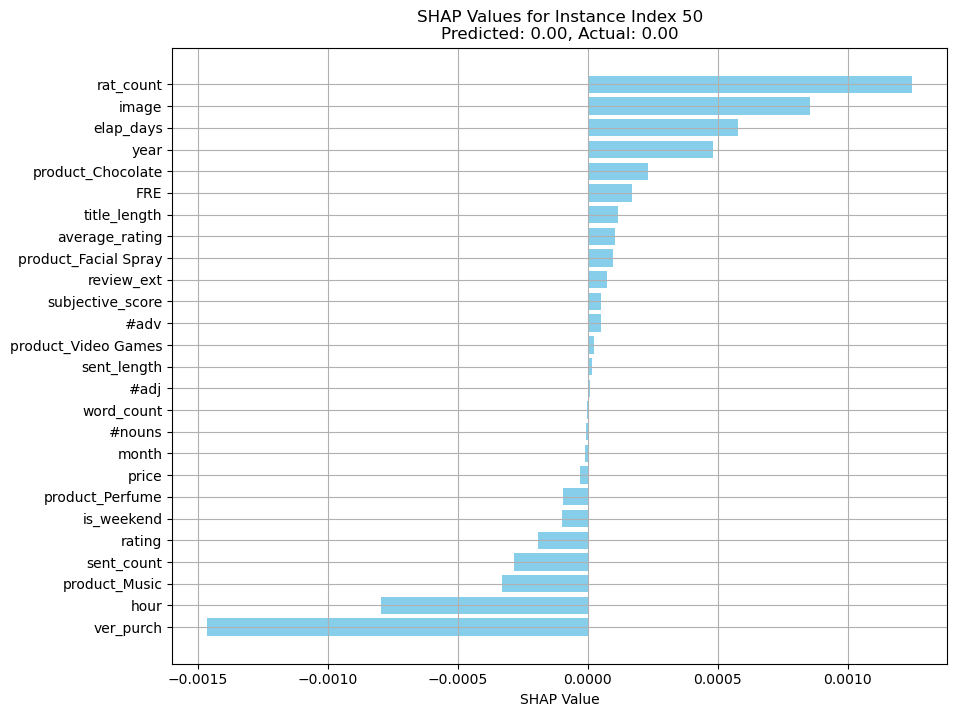

KeyboardInterrupt: 

In [ ]:
# Loop through each instance in the test set
for example_index in range(len(X_test)):
    # Extract SHAP values for the specific instance
    example_shap_values = shap_values_test[example_index]
    # Extract the corresponding predicted and actual value for the instance
    predicted_value = y_pred_default[example_index]
    actual_value = y_test[example_index]

    # Create a DataFrame for plotting
    shap_values_df = pd.DataFrame({
        'feature': X_test_scaled_df.columns,
        'shap_value': example_shap_values
    })

    # Sort the DataFrame based on the SHAP values
    shap_values_df_sorted = shap_values_df.sort_values(by='shap_value', ascending=True)

    # Plot
    plt.figure(figsize=(10, 8))
    plt.barh(shap_values_df_sorted['feature'], shap_values_df_sorted['shap_value'], color='skyblue')
    plt.xlabel('SHAP Value')
    # Include predicted and actual value in the title
    plt.title(f'SHAP Values for Instance Index {example_index}\nPredicted: {predicted_value:.2f}, Actual: {actual_value[0]:.2f}')
    plt.grid(True)
    plt.show()


In [ ]:
# Train Model with specific hyperparameters
best_hyperparams = {'colsample_bytree': 0.8732354792666625, 'gamma': 0.03613182317974, 'learning_rate': 0.001986697844495, 'max_depth': 1100.0, 'min_child_weight': 5.0, 'n_estimators': 10.0, 'reg_alpha': 0.05550987424359057, 'reg_lambda': 2.469762787227609, 'subsample': 0.6244860331308989}

# Train model
xgb_reg = xgb.XGBRegressor(
    objective='reg:pseudohubererror',
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    gamma=best_gamma,
    subsample=best_subsample,
    colsample_bytree=best_colsample_bytree,
    learning_rate=best_learning_rate,
    n_estimators=best_n_estimators,
    reg_alpha=best_reg_alpha,
    reg_lambda=best_reg_lambda
)

# Training the model
xgb_reg.fit(X_train, y_train)

# Predictions on test data
y_pred = xgb_reg.predict(X_test)

# Model evaluation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("\nModel Evaluation:")
print(f"Mean Squared Error on Test Data: {mse}")
print(f"Mean Absolute Error on Test Data: {mae}")